# Exponential Smoothing

In [20]:
# Carregar Bibliotecas
library(dplyr)
library(xts)
library(ggplot2)
library(forecast)
library(tidyverse)

In [2]:
path <- "https://raw.githubusercontent.com/E-man85/projectII/main/dataStaging/grainWeekMultipleVariables.csv"
df <- read.csv(path)
df <- df[, c('store_id','date', 'summed_revenue')]
rm(path)
head(df)
str(df)
dim(df)

,store_id,date,summed_revenue
,<chr>,<chr>,<dbl>
1,S0002,2017-01-08,1813.24
2,S0002,2017-01-15,1896.91
3,S0002,2017-01-22,7404.16
4,S0002,2017-01-29,2078.39
5,S0002,2017-02-05,1745.47
6,S0002,2017-02-12,2235.39


'data.frame':	8301 obs. of  3 variables:
 $ store_id      : chr  "S0002" "S0002" "S0002" "S0002" ...
 $ date          : chr  "2017-01-08" "2017-01-15" "2017-01-22" "2017-01-29" ...
 $ summed_revenue: num  1813 1897 7404 2078 1745 ...


[1] 8301    3

In [3]:
# Alterar tipo da coluna date
df$date <- as.Date(df$date)
str(df)

'data.frame':	8301 obs. of  3 variables:
 $ store_id      : chr  "S0002" "S0002" "S0002" "S0002" ...
 $ date          : Date, format: "2017-01-08" "2017-01-15" ...
 $ summed_revenue: num  1813 1897 7404 2078 1745 ...


## Data Preparation

In [4]:
# Criar listas de dataframes com dados de cada store
# Lista das lojas unicas
stores <- unique(df$store_id)
# Lista para armazenar os dataframes
df_list <- list()
# Loop para criar os dataframes separados
for (store in stores) {
  # filtrar dataframe
  df_store <- df[df$store_id == store,]
  # Adicionar dataframe à lista
  df_list[[store]] <- df_store
}
# Dividir dados treino e teste
# Lista para armazenar os timeseries teste e treino
df_train <- list()
df_test <- list()
# Loop para criar as séries temporais semanais e armazenar nas lista
for (t in names(df_list)) {
  data <- df_list[[t]]
  train <- head(data, -5)
  test <- tail(data, 5)
  df_train[[t]] <- train
  df_test[[t]] <- test
}
# Converter em timeseries ts
# lista para armazenar os timeseries 
ts_real <- list()
ts_train <- list()
ts_test <- list()
# Loop
for(t in names(df_list)){
    data <- df_list[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_real[[t]] <- ts
}
# Loop
for(t in names(df_train)){
    data <- df_train[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_train[[t]] <- ts
}
# Loop
for(t in names(df_test)){
    data <- df_test[[t]]
    ts <- ts(data = data$summed_revenue, frequency = 52)
    ts_test[[t]] <- ts
}
length(ts_train)
length(ts_test)
length(ts_real)

[1] 63

[1] 63

[1] 63

## Simple exponential smoothing
## Holt’s linear trend method
## Damped trend methods

In [5]:
# Simple exponential smoothing 
# Armazenar previsões ses model 
ses_prev <- list()
# Loop
for (ts in names(ts_train)){
    data <- ts_train[[ts]]
    model_ses <- forecast(ses(data), h = 5)
    ses_prev[[ts]] <- model_ses$mean
}
length(ses_prev)
# Simple exponential smoothing com tendência
# Armazenar previsões holt model 
holt_prev <- list()
# Loop
for (ts in names(ts_train)){
    data <- ts_train[[ts]]
    model_holt <- forecast(holt(data), h = 5)
    holt_prev[[ts]] <- model_holt$mean
}
length(holt_prev)
# Métodos de tendência amortecida
# Armazenar previsões damped holt model 
holt_damped_prev <- list()
# Loop
for (ts in names(ts_train)){
    data <- ts_train[[ts]]
    model_holt_damped <- forecast(holt(data, damped=TRUE), h = 5)
    holt_damped_prev[[ts]] <- model_holt_damped$mean
}
length(holt_damped_prev)

[1] 63

[1] 63

[1] 63

**Simple exponential smoothing**

 Este método é adequado para prever dados sem tendência clara ou padrão sazonal. 

**Holt’s linear trend method**

Suavização exponencial simples para permitir a previsão de dados com uma tendência

**Damped trend methods**

Método linear de Holt  com um parâmetro que “amortece” a tendência para uma linha plana em algum momento no futuro.

In [6]:
# Resumo modelo ex: loja S0143
summary(model_ses)
summary(model_holt)
summary(model_holt_damped)


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(y = data) 

  Smoothing parameters:
    alpha = 0.2811 

  Initial states:
    l = 331.8001 

  sigma:  111.8424

     AIC     AICc      BIC 
1985.863 1986.042 1994.645 

Error measures:
                   ME    RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 9.779933 111.029 72.21876 -3.306309 18.90385 0.5302505 0.02418908

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
3.653846       711.1595 567.8277 854.4913 491.9525 930.3665
3.673077       711.1595 562.2732 860.0458 483.4575 938.8615
3.692308       711.1595 556.9185 865.4005 475.2682 947.0507
3.711538       711.1595 551.7436 870.5754 467.3539 954.9651
3.730769       711.1595 546.7315 875.5875 459.6885 962.6304


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(y = data) 

  Smoothing parameters:
    alpha = 0.2656 
    beta  = 1e-04 

  Initial states:
    l = 342.1739 
    b = 2.7252 

  sigma:  112.2554

     AIC     AICc      BIC 
1988.836 1989.291 2003.472 

Error measures:
                     ME     RMSE      MAE       MPE     MAPE      MASE
Training set -0.1342417 110.6165 72.93123 -6.311735 19.62087 0.5354816
                   ACF1
Training set 0.03436777

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
3.653846       707.9174 564.0563 851.7784 487.9009 927.9339
3.673077       710.6407 561.7898 859.4915 482.9930 938.2884
3.692308       713.3640 559.6817 867.0463 478.3272 948.4008
3.711538       716.0873 557.7174 874.4572 473.8815 958.2931
3.730769       718.8106 555.8846 881.7366 469.6367 967.9844


Forecast method: Damped Holt's method

Model Information:
Damped Holt's method 

Call:
 holt(y = data, damped = TRUE) 

  Smoothing parameters:
    alpha = 0.2778 
    beta  = 1e-04 
    phi   = 0.8855 

  Initial states:
    l = 352.8578 
    b = -5.549 

  sigma:  113.0338

     AIC     AICc      BIC 
1991.710 1992.351 2009.273 

Error measures:
                   ME     RMSE      MAE       MPE    MAPE      MASE       ACF1
Training set 10.38199 110.9672 72.18073 -3.086069 18.8476 0.5299713 0.02404376

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
3.653846       708.5033 563.6447 853.3619 486.9612 930.0454
3.673077       708.5744 558.2251 858.9236 478.6350 938.5137
3.692308       708.6373 552.9880 864.2866 470.5923 946.6824
3.711538       708.6931 547.9159 869.4703 462.8055 954.5806
3.730769       708.7424 542.9937 874.4911 455.2516 962.2332


	Ljung-Box test

data:  Residuals from Simple exponential smoothing
Q* = 17.255, df = 28, p-value = 0.9434

Model df: 0.   Total lags used: 28



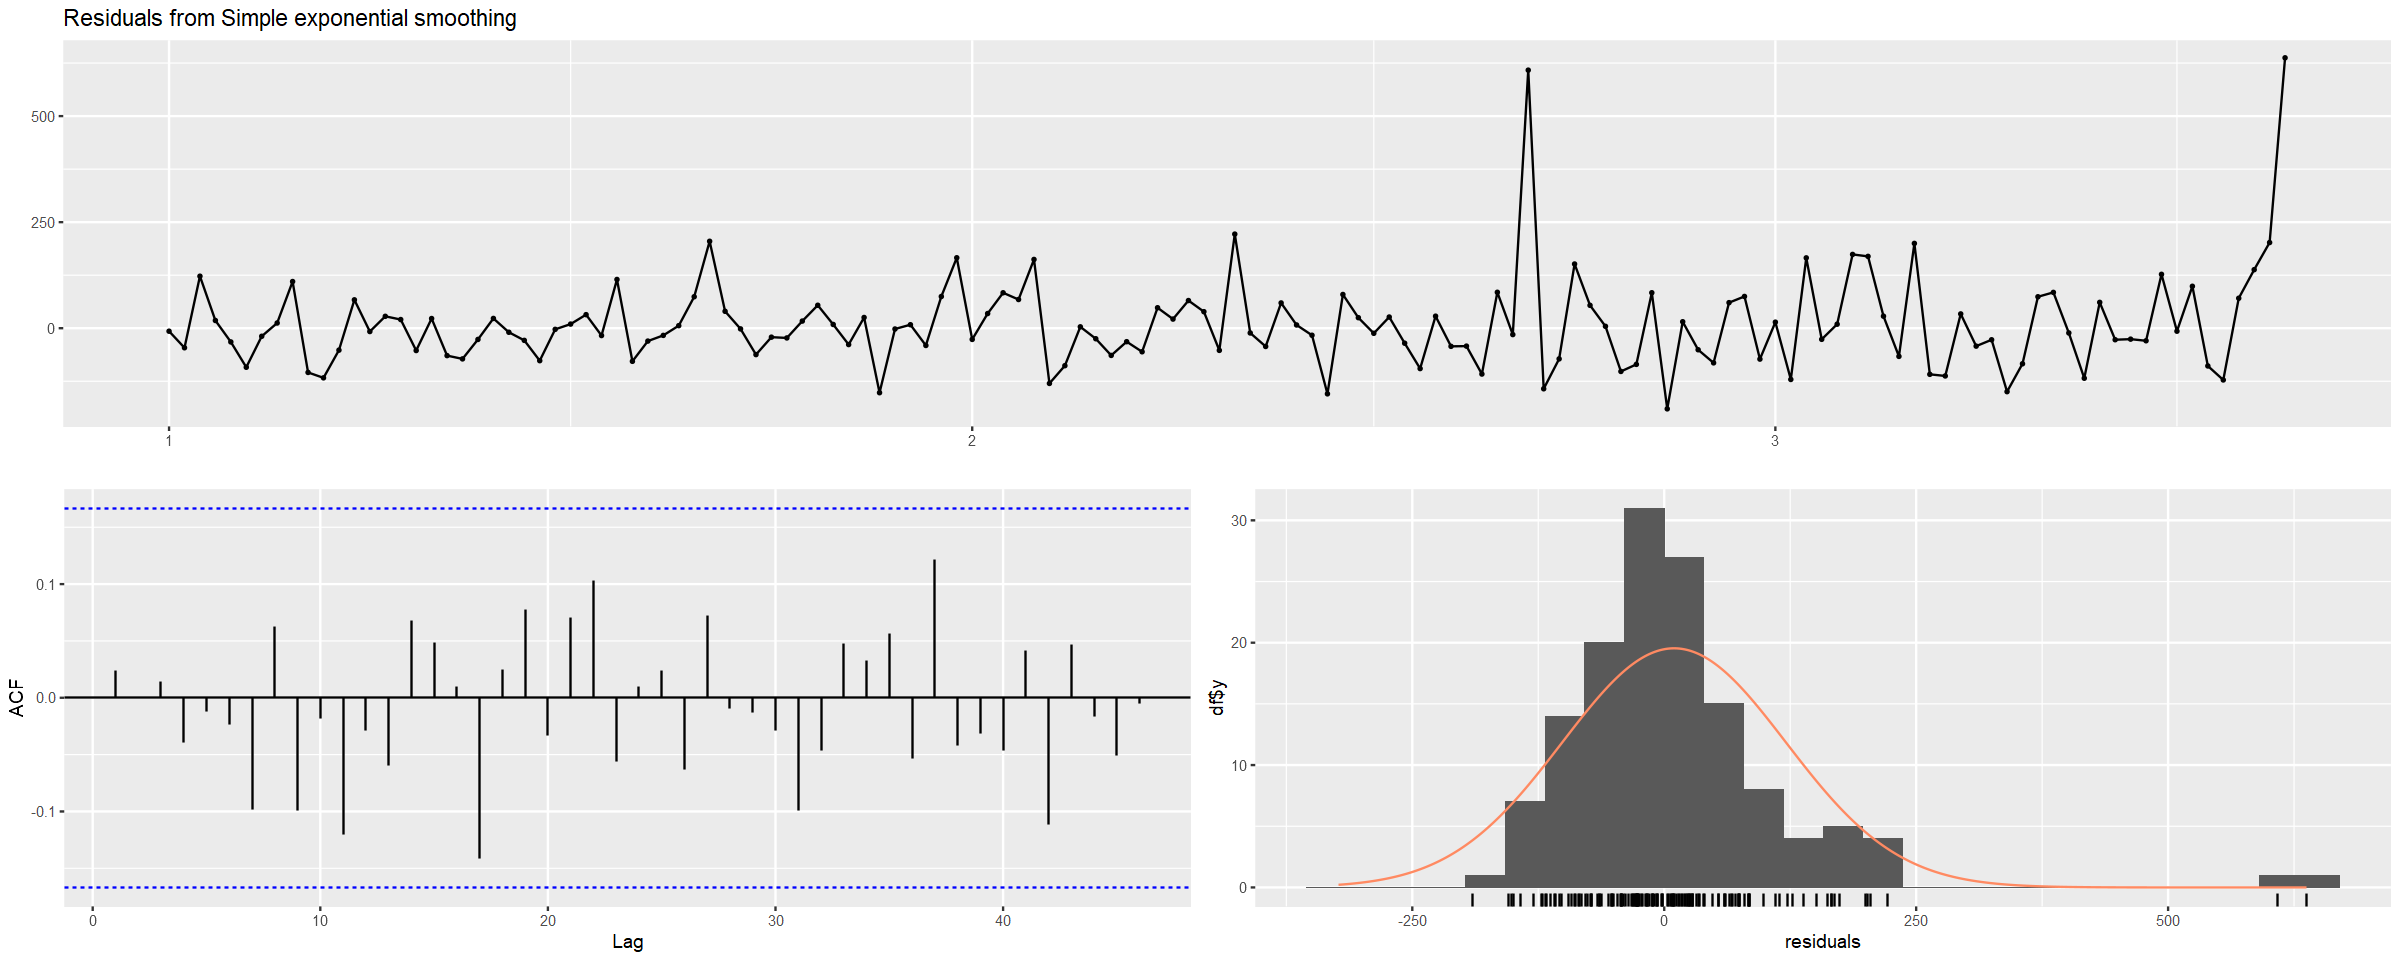


	Ljung-Box test

data:  Residuals from Holt's method
Q* = 17.352, df = 28, p-value = 0.9413

Model df: 0.   Total lags used: 28



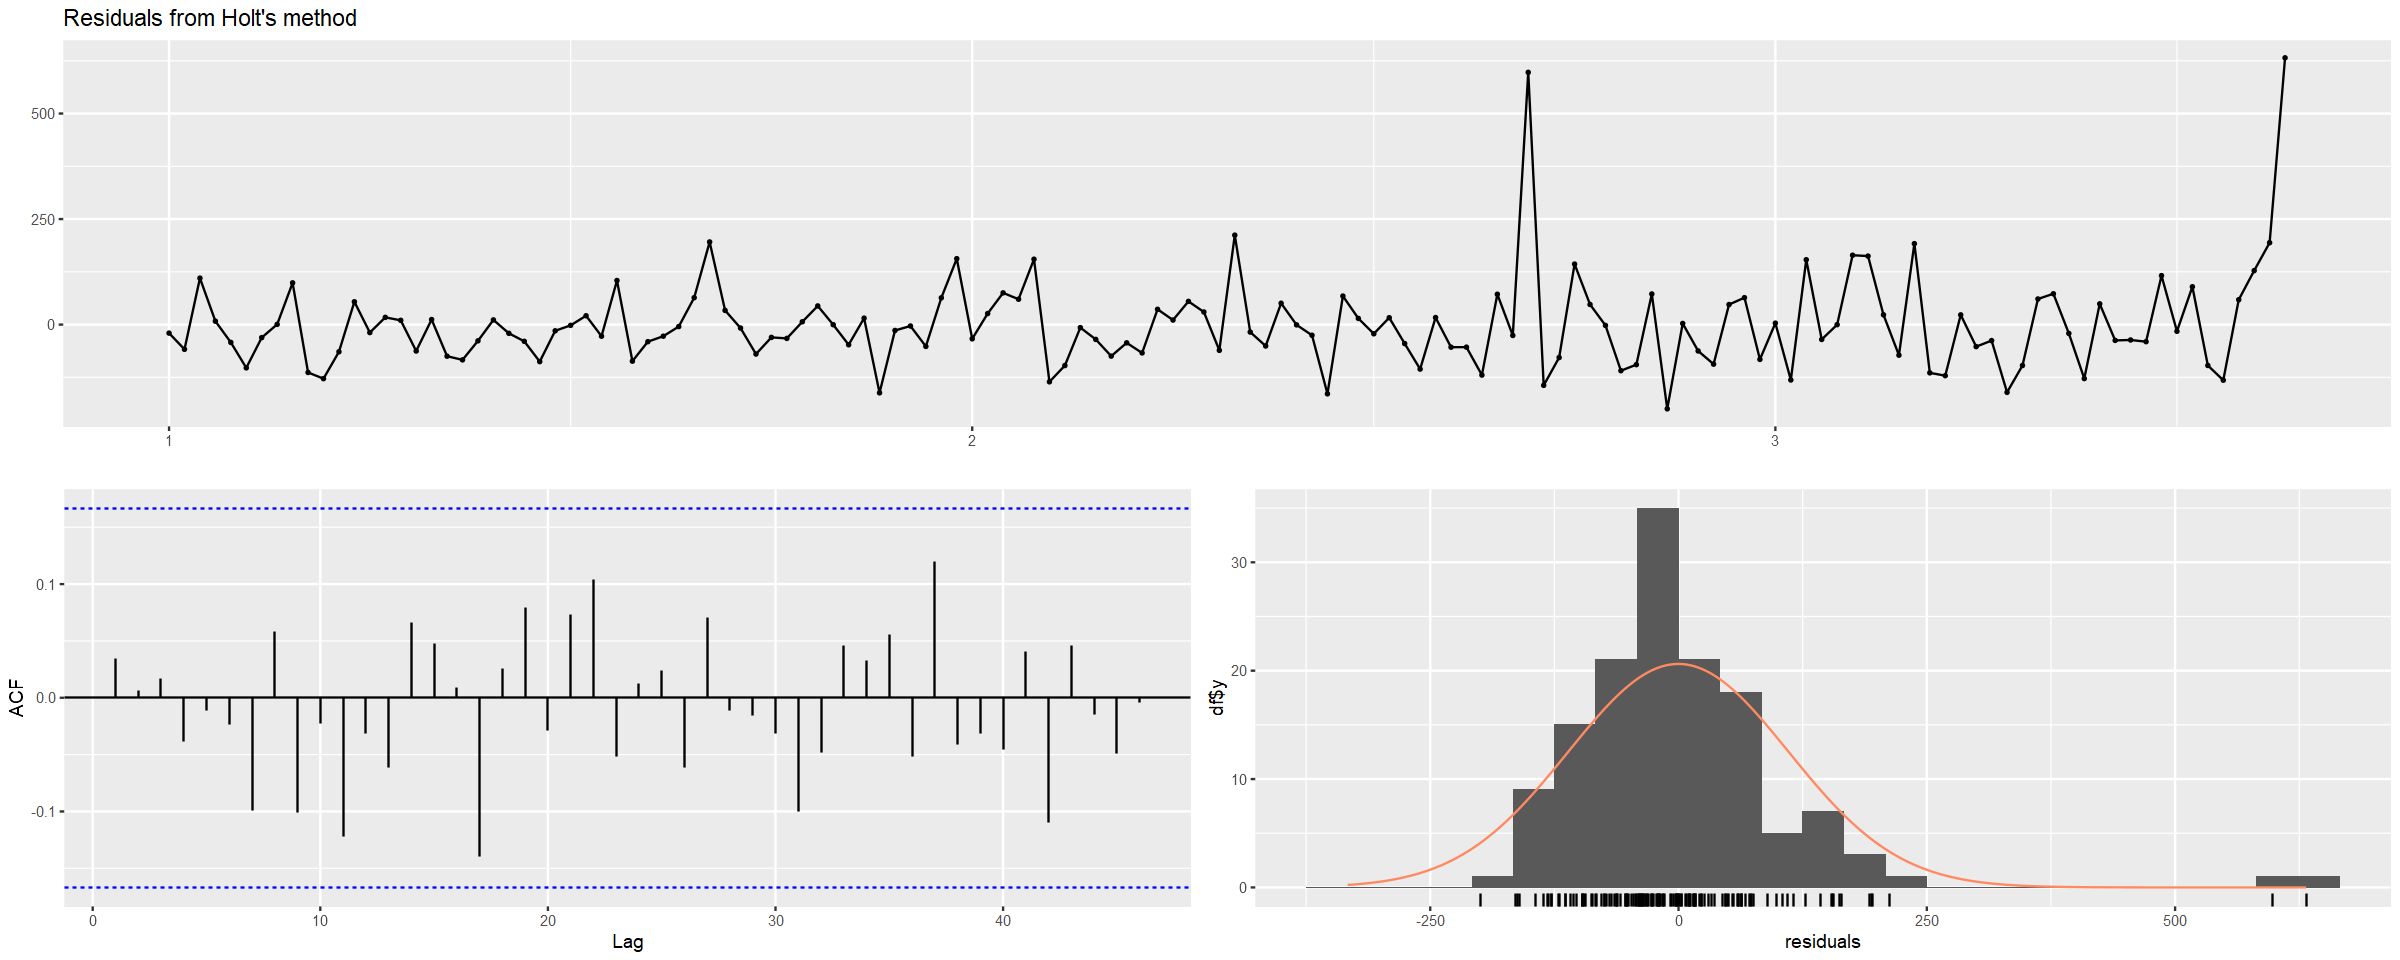


	Ljung-Box test

data:  Residuals from Damped Holt's method
Q* = 17.456, df = 28, p-value = 0.939

Model df: 0.   Total lags used: 28



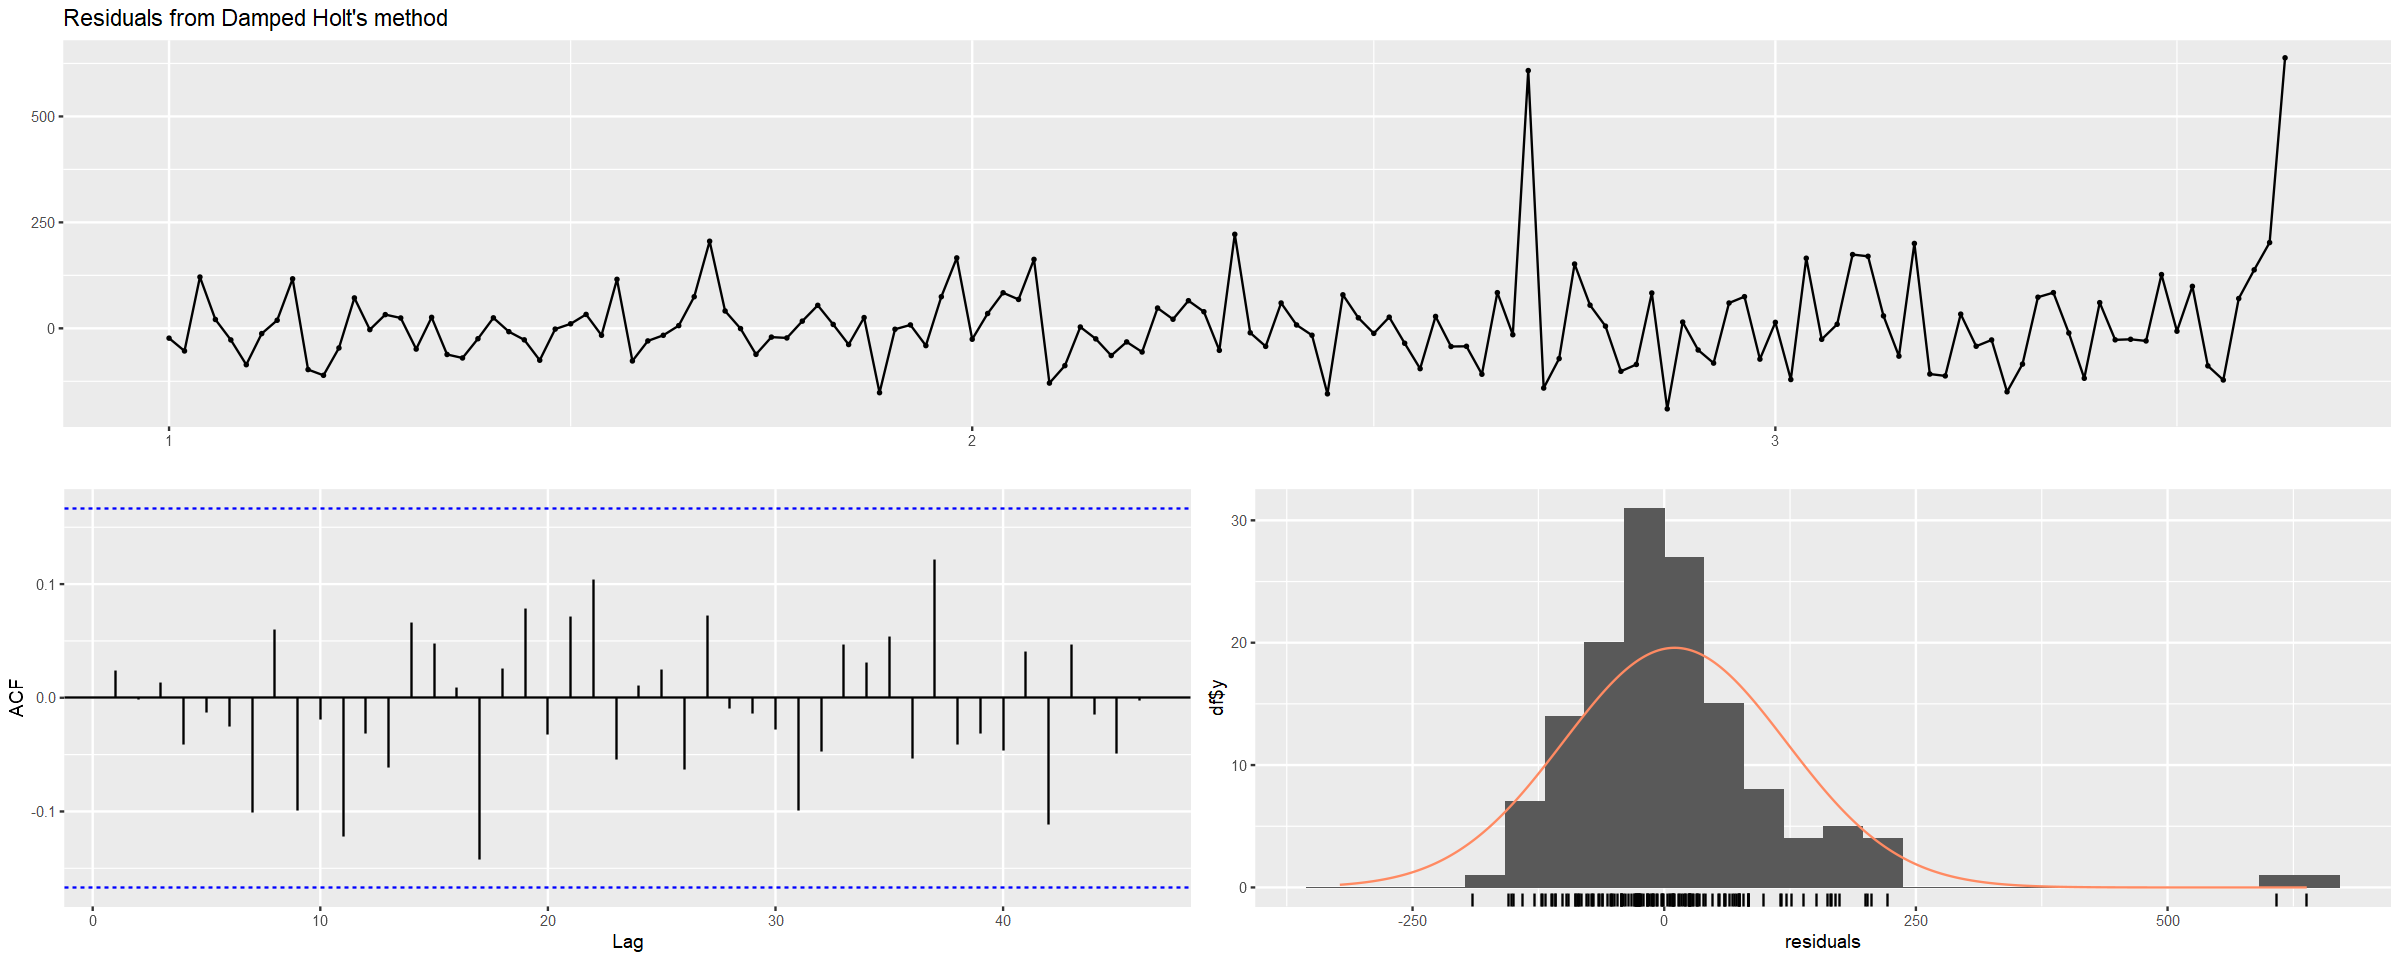

In [7]:
# Ver resuiduos ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 8)
par(mfrow = c(1, 3))
checkresiduals(model_ses)
checkresiduals(model_holt)
checkresiduals(model_holt_damped)

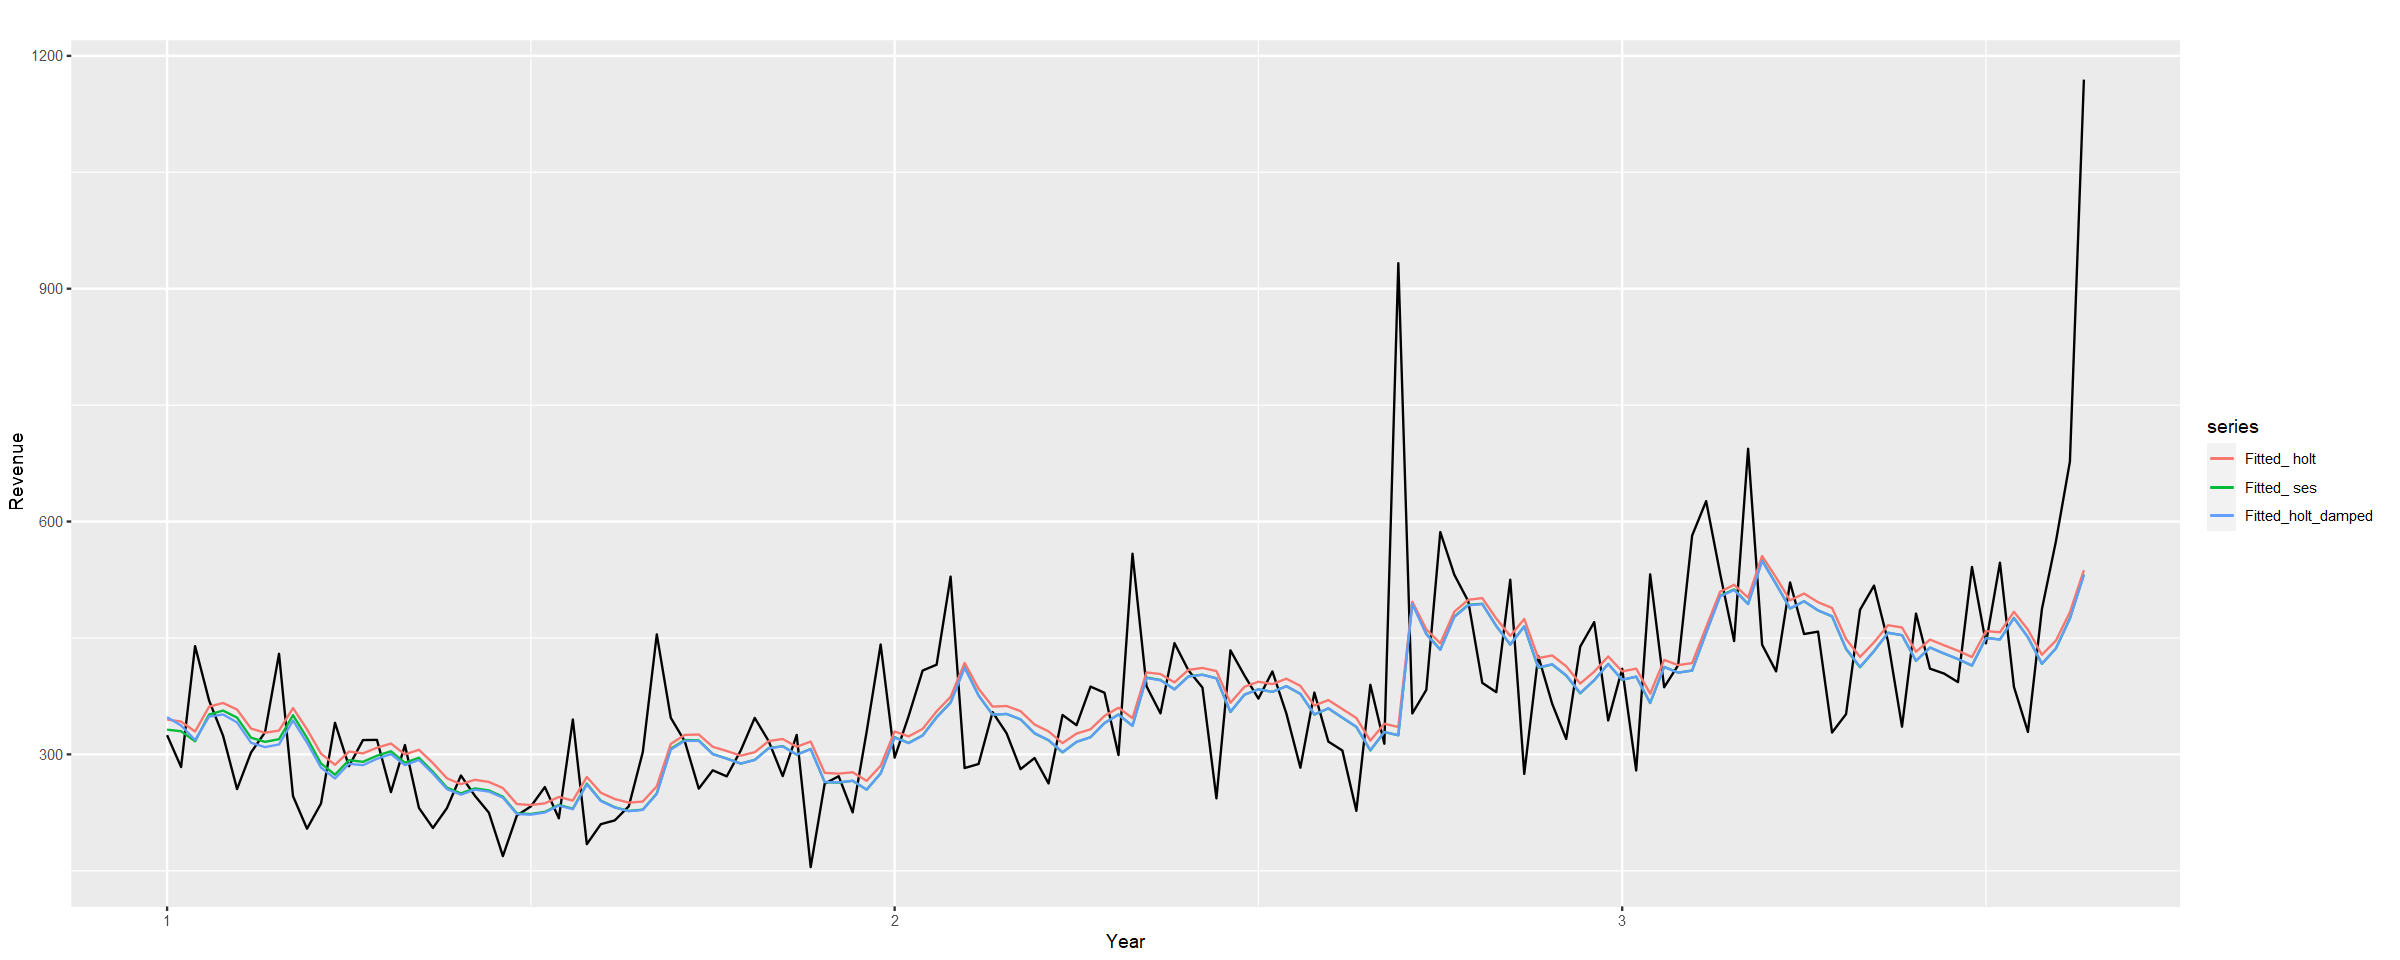

In [8]:
# Fitted modelo  ex: loja S0143
autoplot(ts_train[[63]]) +
  autolayer(fitted(model_ses), series="Fitted_ ses") +
  autolayer(fitted(model_holt), series="Fitted_ holt") +
  autolayer(fitted(model_holt_damped), series="Fitted_holt_damped") +
  ylab("Revenue") + xlab("Year")

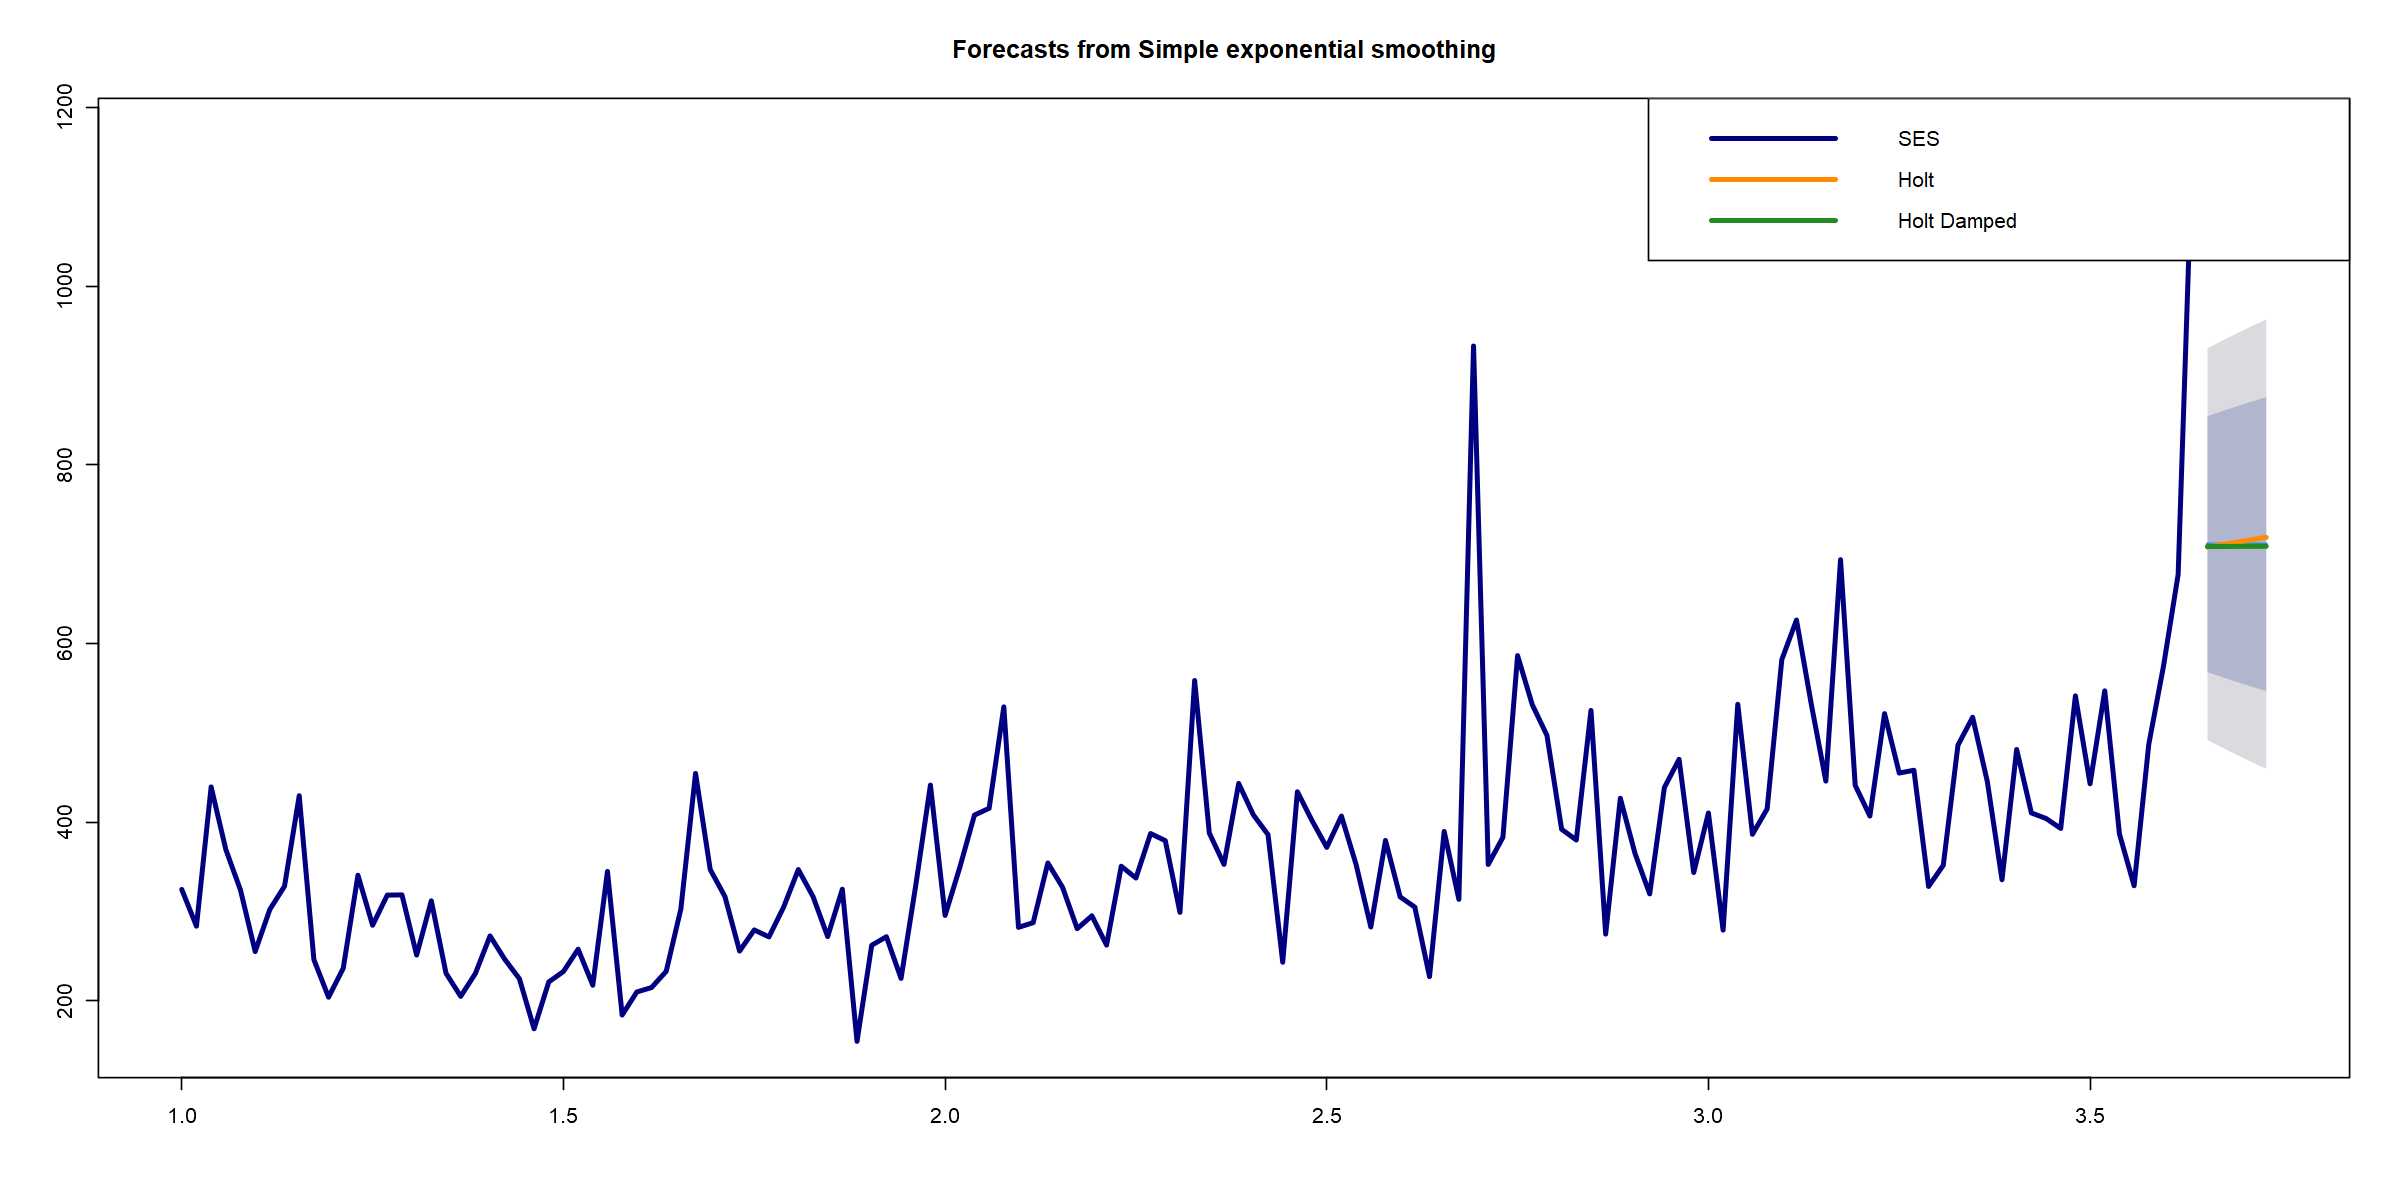

In [9]:
# Ver previsões ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
# Obter as previsões dos modelos SES, Holt e Holt com amortecimento
predict_ses_model <- forecast(model_ses)
predict_holt_model <- forecast(model_holt)
predict_holt_damped_model <- forecast(model_holt_damped)
# Plotar as previsões dos modelos SES
plot(predict_ses_model, col = "navyblue", lwd = 3)
# Adicionar as previsões dos modelos Holt e Holt com amortecimento ao gráfico
lines(predict_holt_model$mean, col = "darkorange", lwd = 3)
lines(predict_holt_damped_model$mean, col = "forestgreen", lwd = 3)
# Adicionar rótulos e legendas ao gráfico
legend("topright", legend = c("SES", "Holt", "Holt Damped"), col = c("navyblue", "darkorange", "forestgreen"), lwd = 3)

## Model ETS (Error, Trend, Seasonality) 
## Model STLF (Seasonal and Trend decomposition using Loess and Fourier) 

In [10]:
# Model ETS (Error, Trend, Seasonality) 
# Armazenar previsões ets model 
ets_prev <- list()
# Loop
for (ts in names(ts_train)){
    data <- ts_train[[ts]]
    data <- tail(data, 52)
    model_ets <- forecast(ets(data), h = 5)
    ets_prev[[ts]] <- model_ets$mean
}
length(ets_prev)
# Model STLF (Seasonal and Trend decomposition using Loess and Fourier) 
# O modelo STLF é particularmente útil para dados com tendência e sazonalidade, pois é capaz de capturar tanto os padrões sazonais quanto a tendência de longo prazo.
# Armazenar previsões stlf model 
stlf_prev <- list()
# Loop
for (ts in names(ts_train)){
  if (ts %in% c("S0005", "S0007", "S0036", "S0046","S0061","S0071", "S0076", "S0092","S0109","S0136")) {
    # series que não têm 2 periodos completos
    stlf_prev[[ts]] <- rep(NA, 5)
  } else {
    data <- ts_train[[ts]]
    model_stlf <- stlf(data,5)
    stlf_prev[[ts]] <- model_stlf$mean
  }
}
length(stlf_prev)

[1] 63

[1] 63

Model STLF -Este modelo tem em conta pelo menos 2 periodos anteriores para avaliar tendência e sazonalidade, por este fato exitem lojam sem previsão de valores uma vez que não existe 2 periodos de histórico. 

In [11]:
# Resumo modelo ex: loja S0143
summary(model_ets)
summary(model_stlf)


Forecast method: ETS(M,N,N)

Model Information:
ETS(M,N,N) 

Call:
 ets(y = data) 

  Smoothing parameters:
    alpha = 0.3416 

  Initial states:
    l = 747.428 

  sigma:  0.316

     AIC     AICc      BIC 
728.1189 728.6189 733.9727 

Error measures:
                    ME     RMSE      MAE       MPE     MAPE MASE         ACF1
Training set 0.7752591 161.8868 115.8079 -7.442602 25.01509  NaN -0.001184455

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
3.653846       761.1983 452.9103 1069.486 289.7125 1232.684
3.673077       761.1983 433.7257 1088.671 260.3722 1262.024
3.692308       761.1983 415.3989 1106.998 232.3437 1290.053
3.711538       761.1983 397.7978 1124.599 205.4251 1316.972
3.730769       761.1983 380.8194 1141.577 179.4589 1342.938


Forecast method: STL +  ETS(M,A,N)

Model Information:
ETS(M,A,N) 

Call:
 ets(y = na.interp(x), model = etsmodel, allow.multiplicative.trend = allow.multiplicative.trend) 

  Smoothing parameters:
    alpha = 0.013 
    beta  = 0.013 

  Initial states:
    l = 327.4406 
    b = -4.3076 

  sigma:  0.2403

     AIC     AICc      BIC 
1911.837 1912.291 1926.473 

Error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE      ACF1
Training set 8.972574 88.71027 60.26973 -1.030193 16.51766 0.4425173 0.1592575

Forecasts:
         Point Forecast    Lo 80     Hi 80    Lo 95     Hi 95
3.653846       547.0500 377.8853  716.2146 288.3349  805.7650
3.673077       593.7861 420.9418  766.6304 329.4436  858.1286
3.692308       864.2095 687.6134 1040.8056 594.1291 1134.2900
3.711538       565.9789 385.5318  746.4259 290.0090  841.9487
3.730769       561.4158 376.9931  745.8385 279.3657  843.4660


	Ljung-Box test

data:  Residuals from ETS(M,N,N)
Q* = 5.0686, df = 10, p-value = 0.8865

Model df: 0.   Total lags used: 10



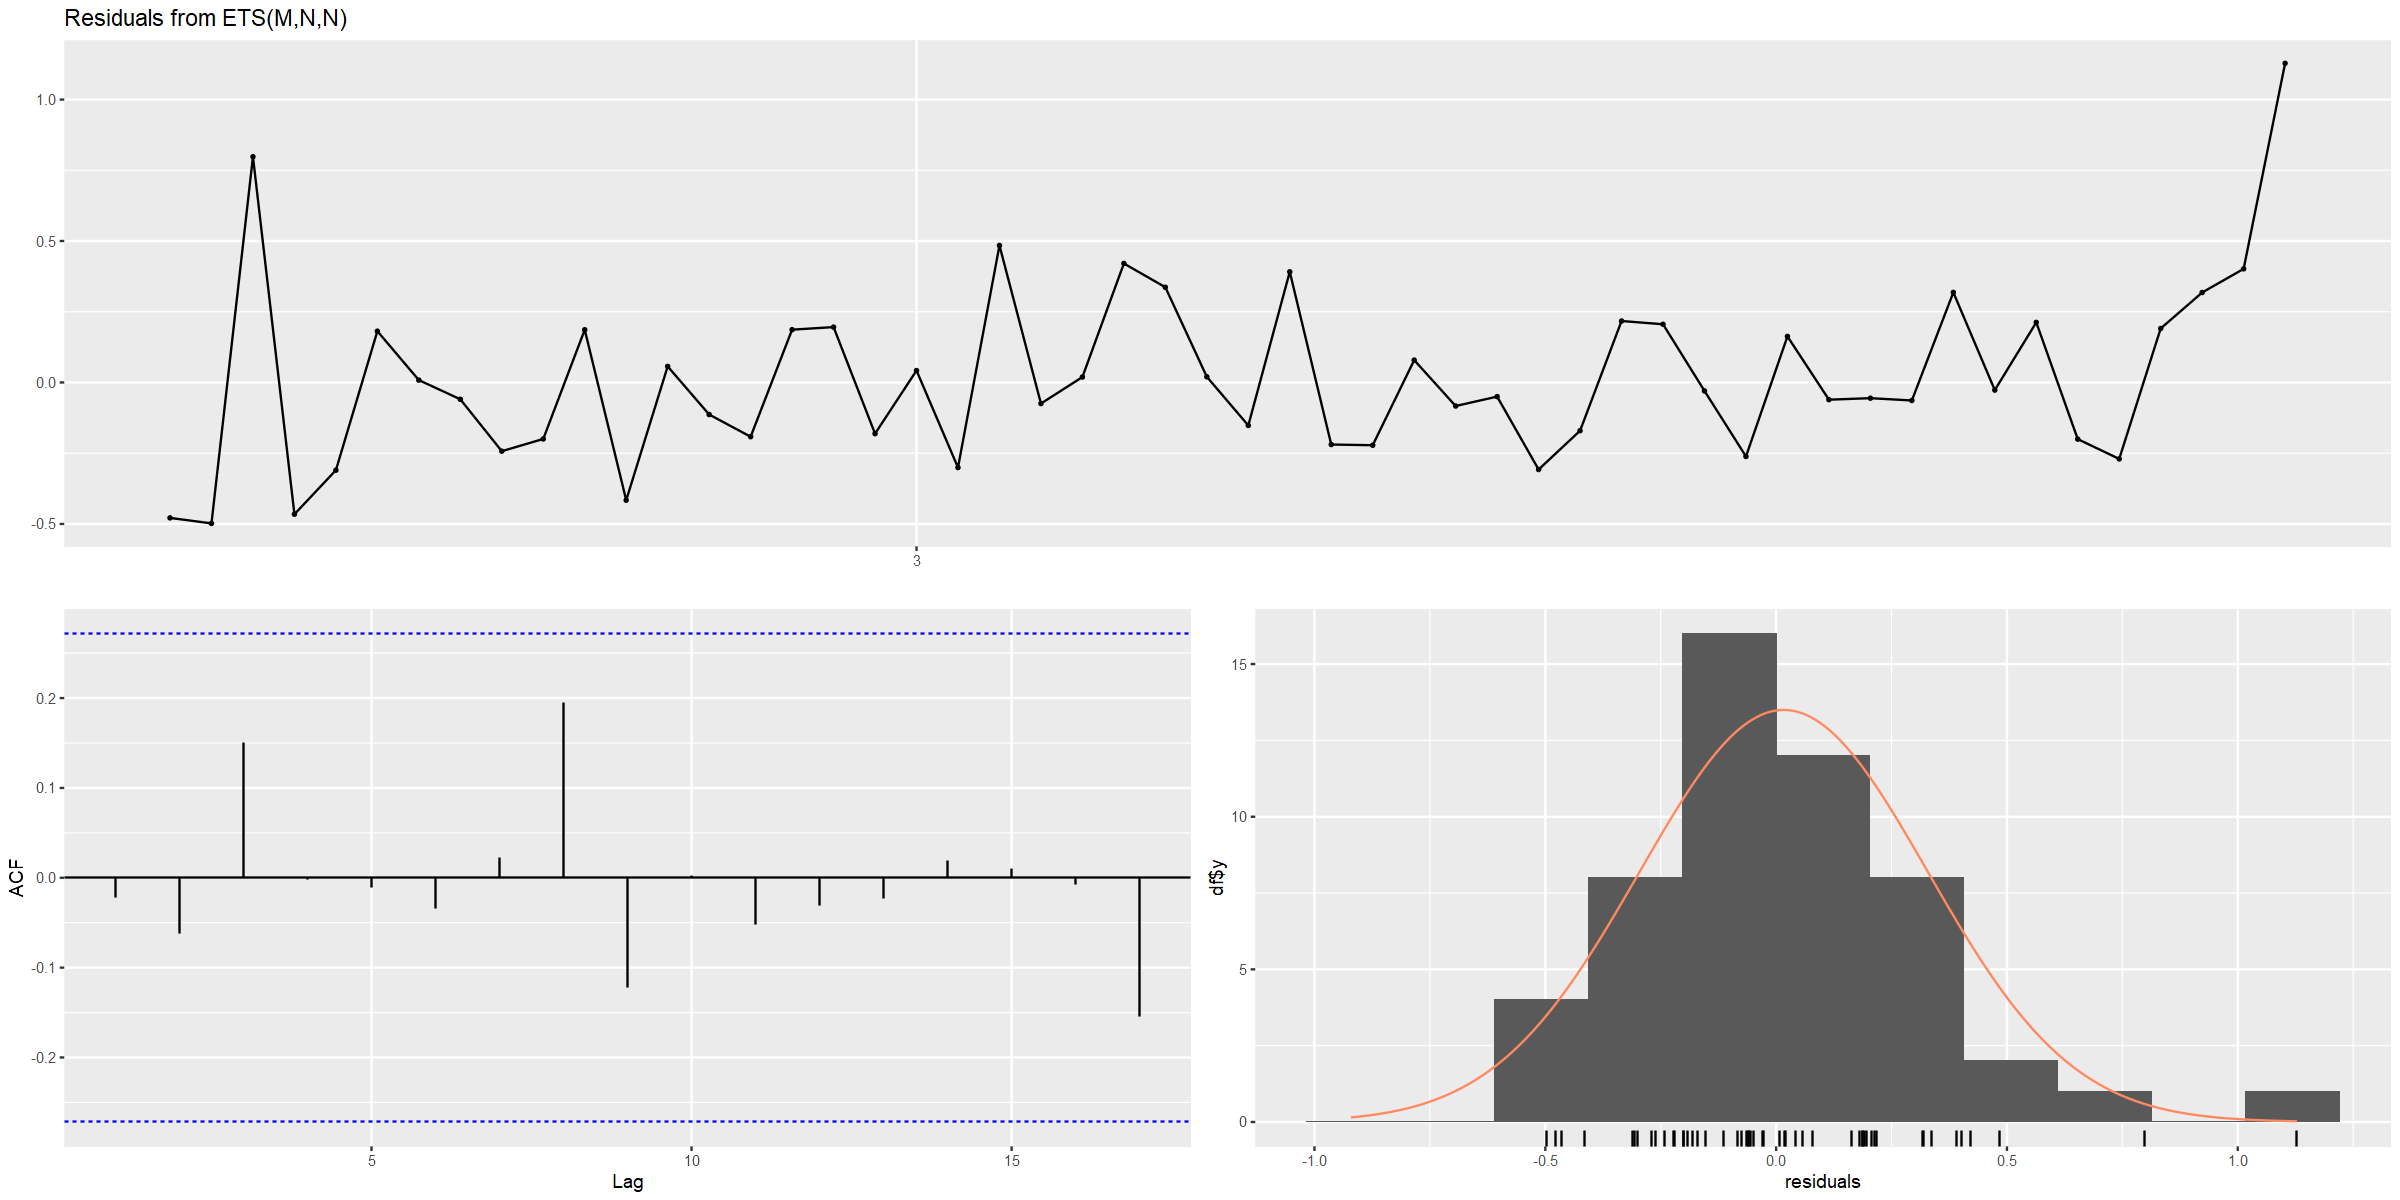


	Ljung-Box test

data:  Residuals from STL +  ETS(M,A,N)
Q* = 47.115, df = 28, p-value = 0.01332

Model df: 0.   Total lags used: 28



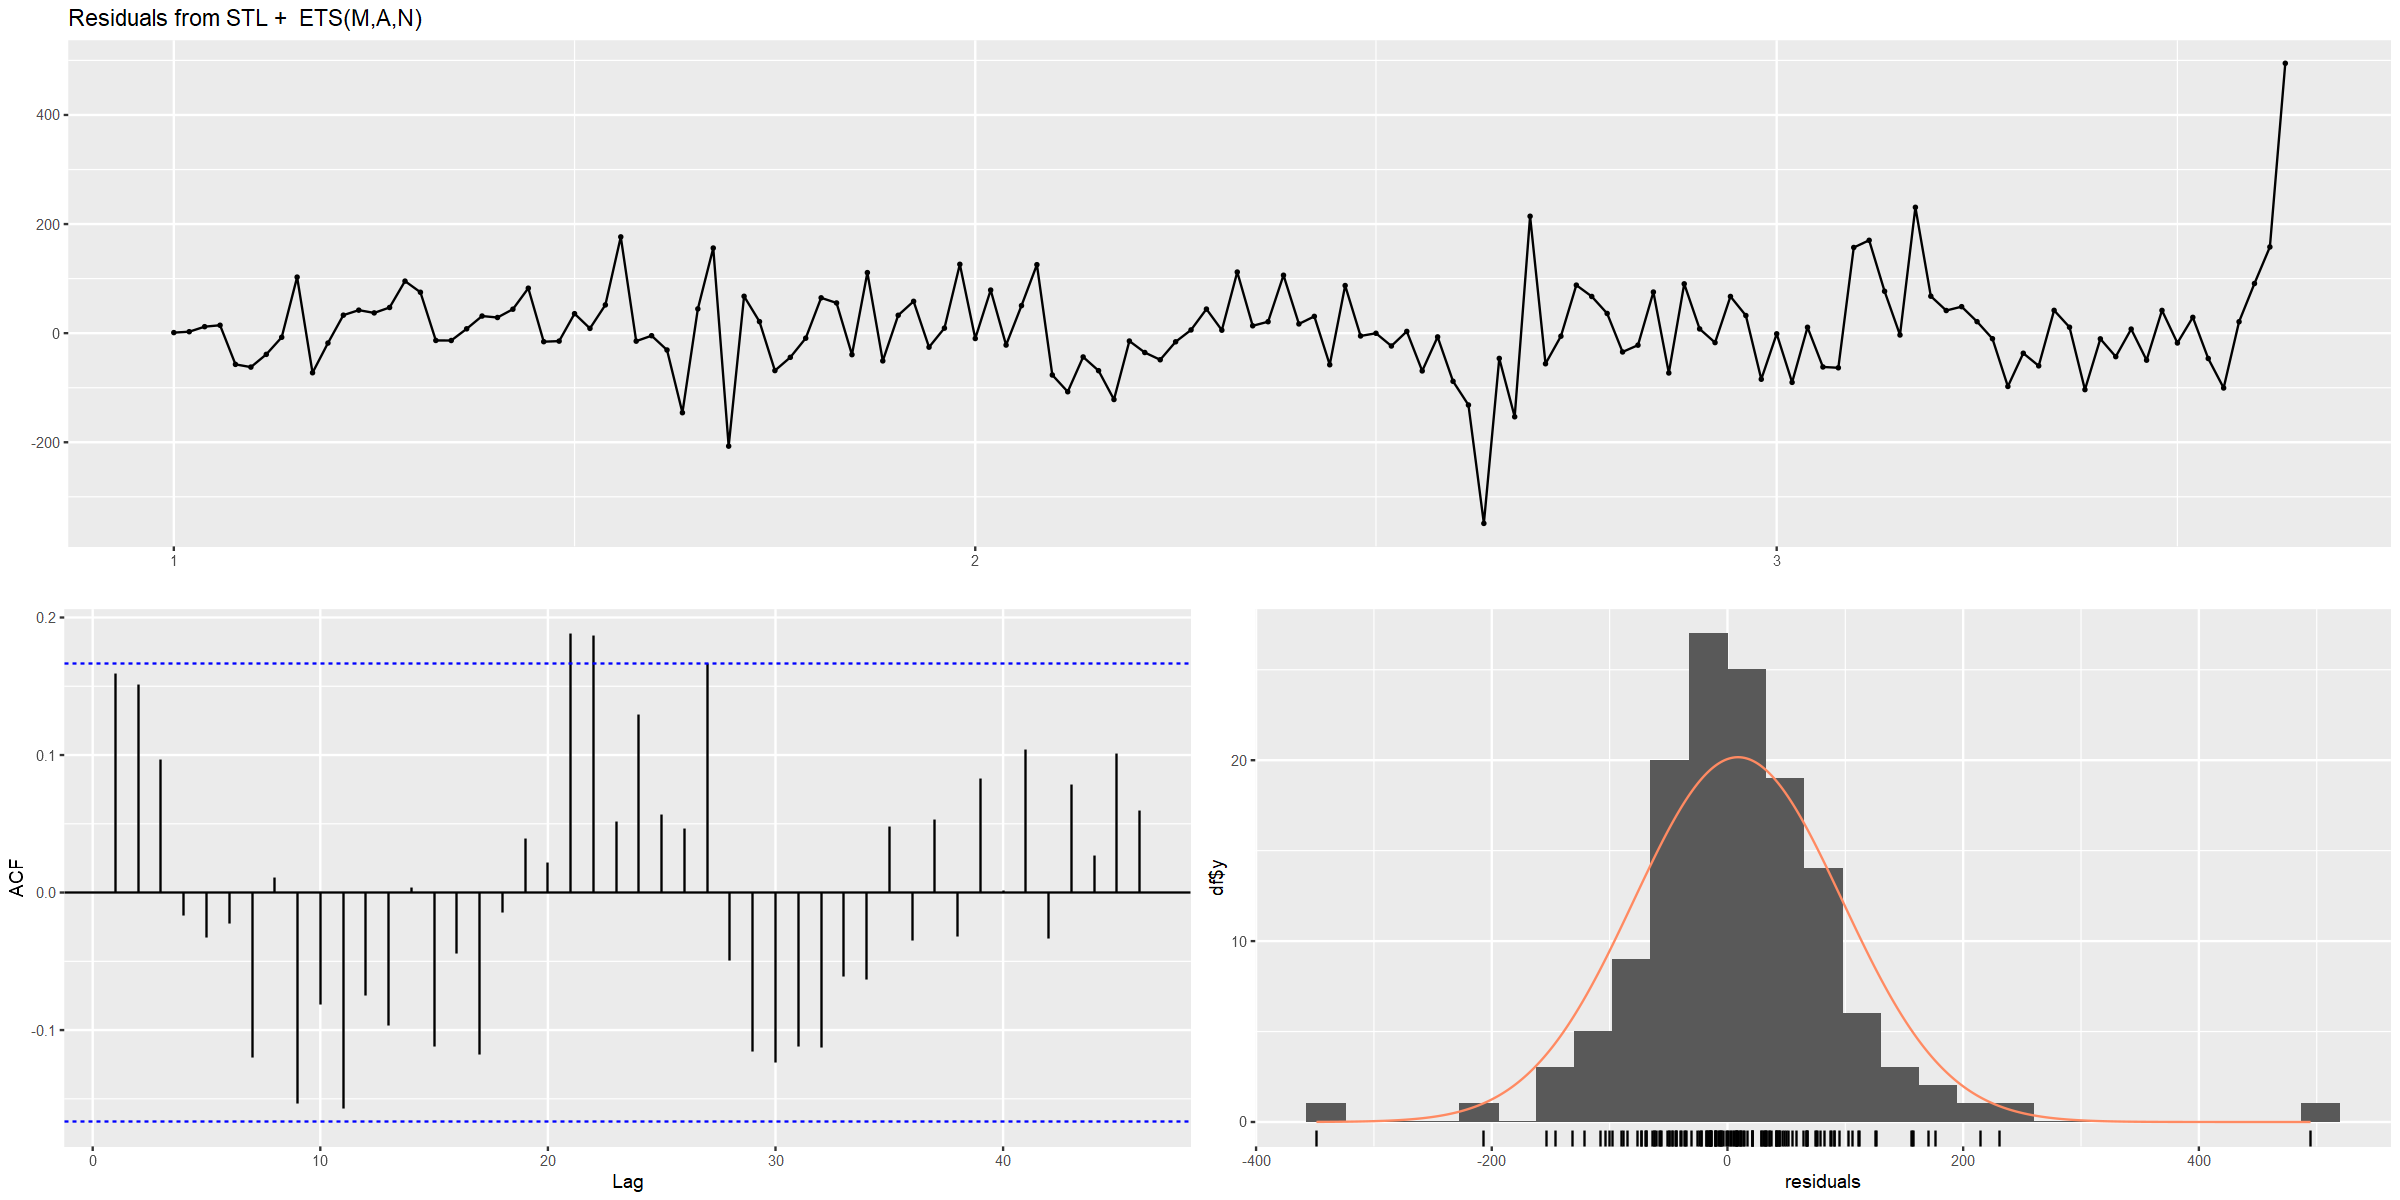

In [12]:
# Ver resuiduos ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
checkresiduals(model_ets)
checkresiduals(model_stlf)

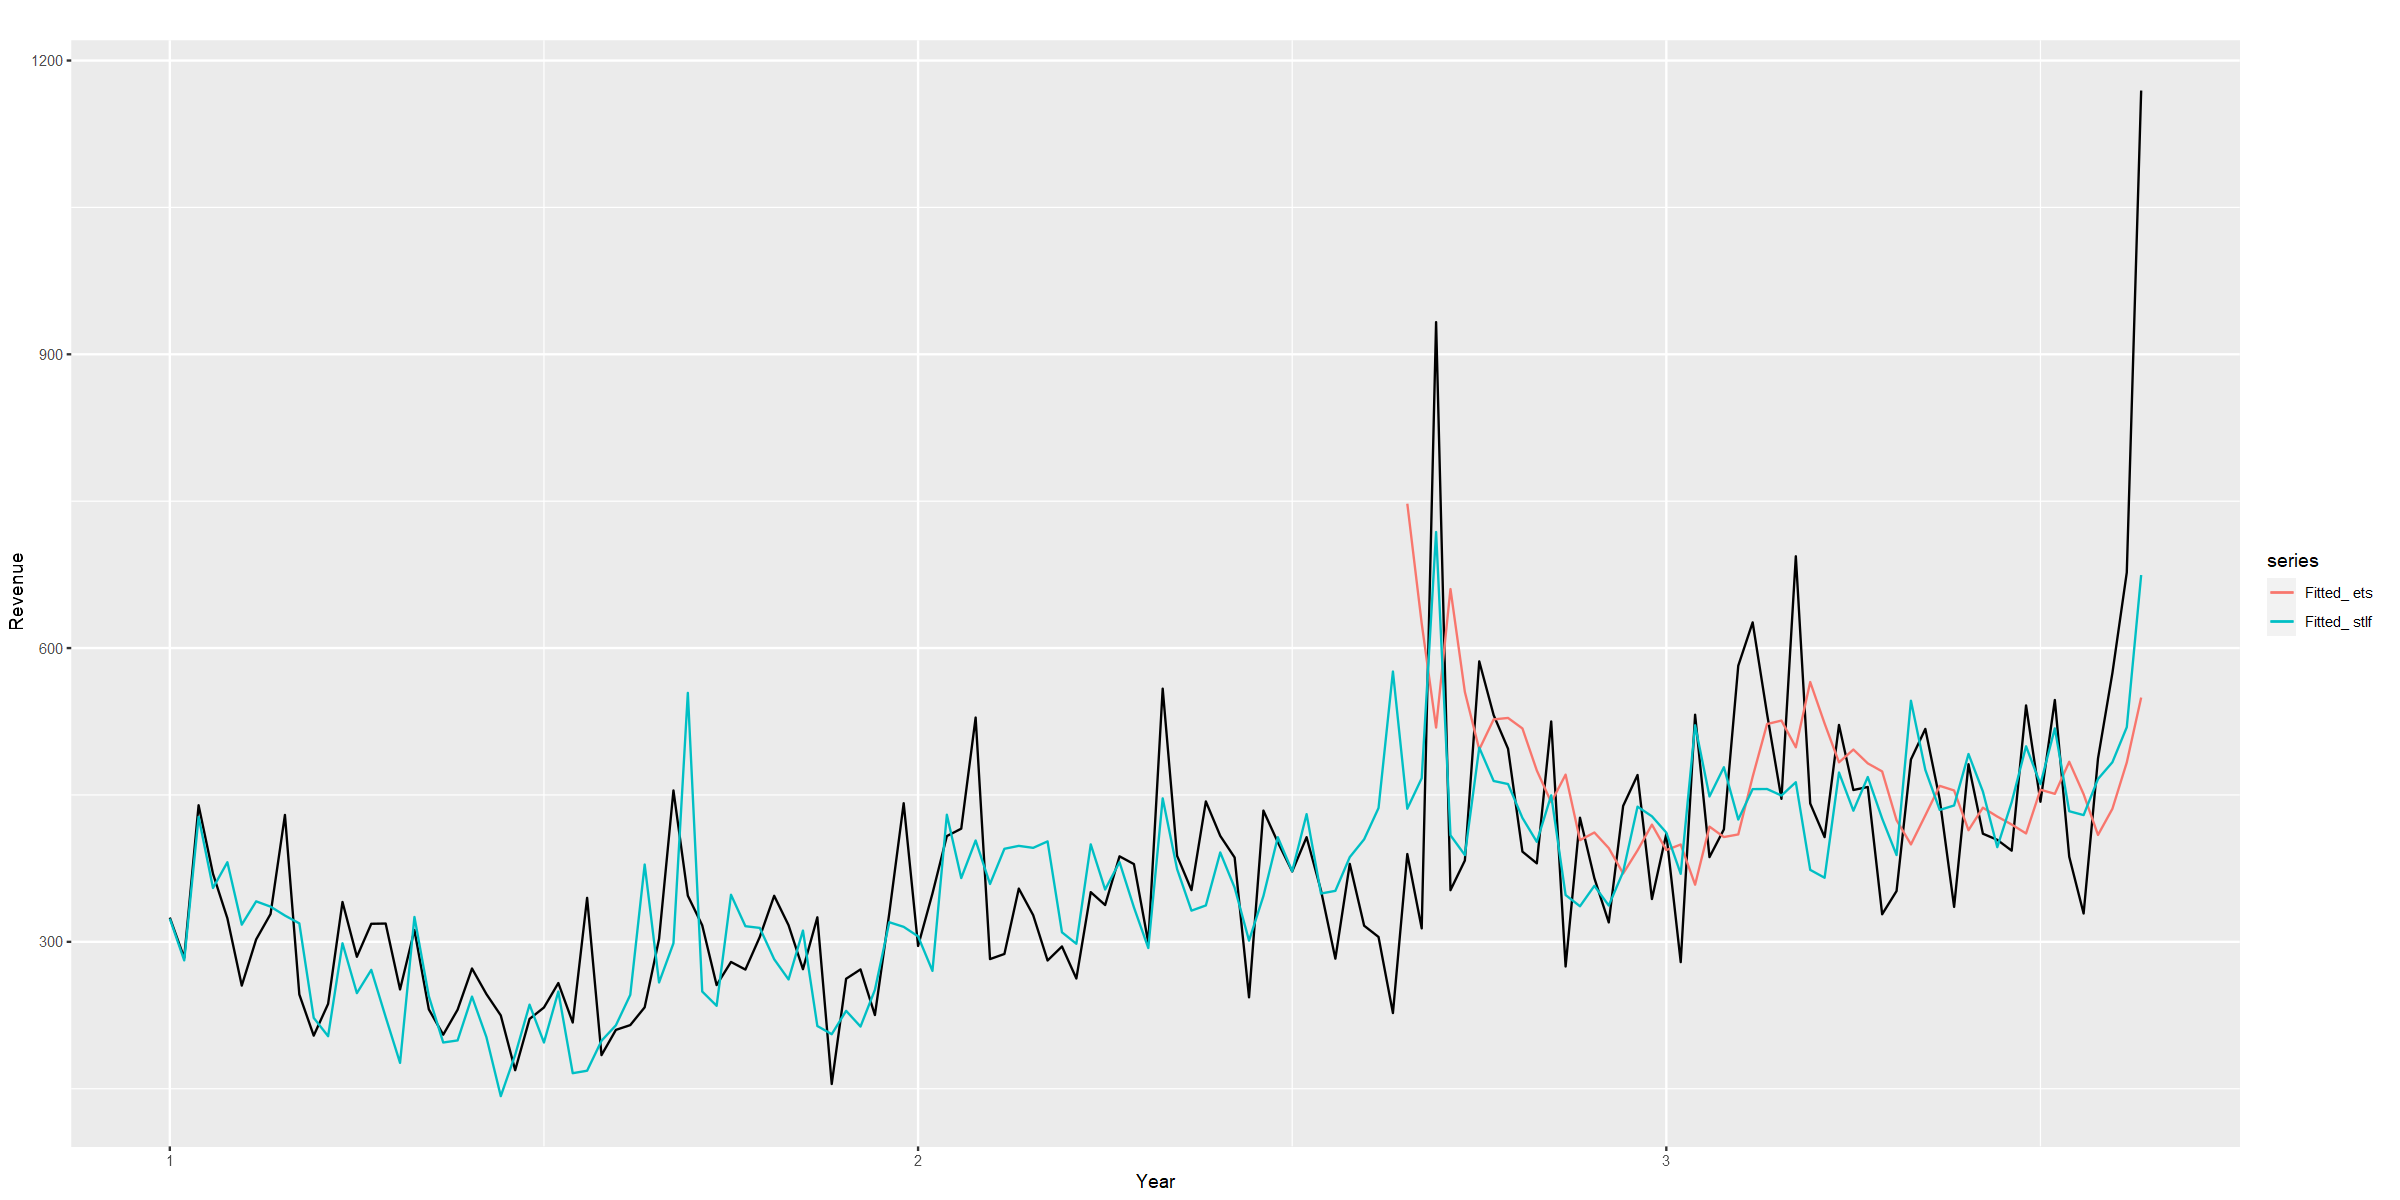

In [13]:
# Fitted modelo  ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
autoplot(ts_train[[63]]) +
  autolayer(fitted(model_ets), series="Fitted_ ets") +
  autolayer(fitted(model_stlf), series="Fitted_ stlf") +
  ylab("Revenue") + xlab("Year")   

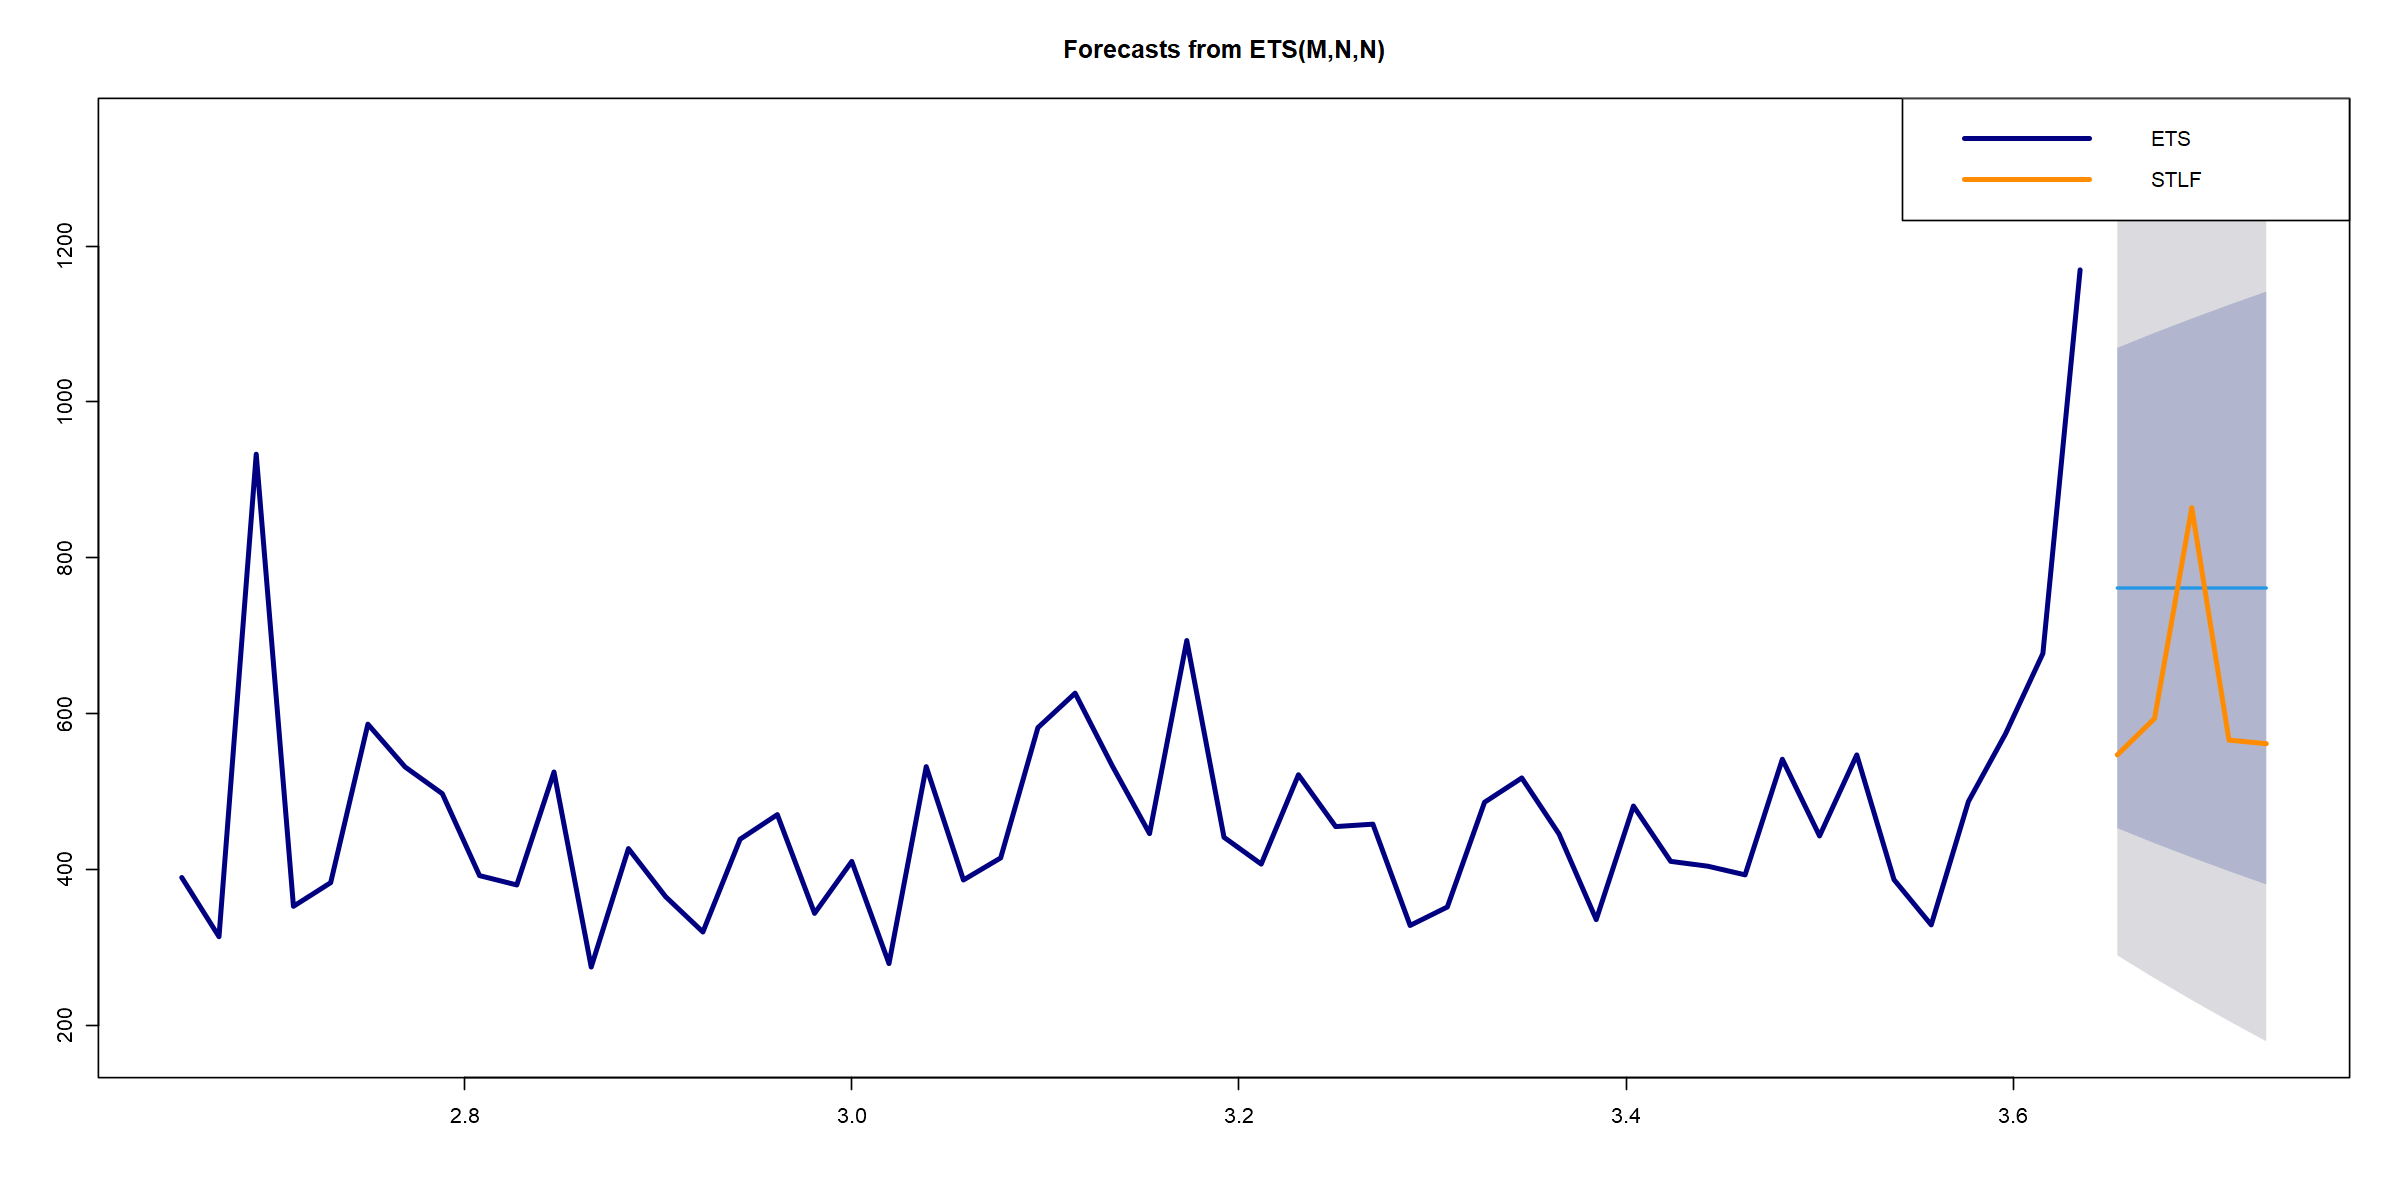

In [14]:
# Ver previsões ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
# Obter as previsões dos modelos SES, Holt e Holt com amortecimento
predict_ets_model <- forecast(model_ets)
predict_stlf_model <- forecast(model_stlf)
# Plotar as previsões dos modelos 
plot(predict_ets_model, col = "navyblue", lwd = 3)
# Adicionar as previsões dos modelos Holt e Holt com amortecimento ao gráfico
lines(predict_stlf_model$mean, col = "darkorange", lwd = 3)
# Adicionar rótulos e legendas ao gráfico
legend("topright", legend = c("ETS", "STLF"), col = c("navyblue", "darkorange"), lwd = 3)

## Evaluation Dataframe

In [15]:
# Criar dataframe com resultados reais
prev <- do.call(rbind, df_test)
# Inserir o nome dos dataframes como uma coluna chamada "store_id"
prev$store_id <- rep(names(df_test), sapply(df_test, nrow))
# criar dataframe com os resultados ses
result <- do.call(rbind, ses_prev)
store_id <-names(ses_prev)
# Combinação do índice com a matriz
result_ses <- data.frame(store_id = store_id, result)
result_ses <- result_ses %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "ses_revenue")
# criar dataframe com os resultados hold
result <- do.call(rbind, holt_prev)
store_id <-names(holt_prev)
# Combinação do índice com a matriz
result_hold <- data.frame(store_id = store_id, result)
result_hold <- result_hold %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "hold_revenue")
# criar dataframe com os resultados hold_damped
result <- do.call(rbind, holt_damped_prev)
store_id <-names(holt_damped_prev)
# Combinação do índice com a matriz
result_hold_damped <- data.frame(store_id = store_id, result)
result_hold_damped <- result_hold_damped %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "hold_damped_revenue")
# criar dataframe com os resultados ets
result <- do.call(rbind, ets_prev)
store_id <-names(ets_prev)
# Combinação do índice com a matriz
result_ets <- data.frame(store_id = store_id, result)
result_ets <- result_ets %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "ets_revenue")
# criar dataframe com os resultados lm
result <- do.call(rbind, stlf_prev)
store_id <-names(stlf_prev)
# Combinação do índice com a matriz
result_stlf <- data.frame(store_id = store_id, result)
result_stlf <- result_stlf %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "stlf_revenue")
# Juntar resultados no dataframe prev
prev$ses_revenue <- result_ses$ses_revenue
prev$hold_revenue <- result_hold$hold_revenue
prev$hold_damped_revenue <- result_hold_damped$hold_damped_revenue
prev$ets_revenue <- result_ets$ets_revenue
prev$stlf_revenue <- result_stlf$stlf_revenue
# Ver 20 linhas aleatórias
prev %>% sample_n(20)

,store_id,date,summed_revenue,ses_revenue,hold_revenue,hold_damped_revenue,ets_revenue,stlf_revenue
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S0058.3569,S0058,2019-09-22,1747.08,3769.1705,3882.3044,3514.8825,6399.1883,2965.9327
S0056.3424,S0056,2019-09-08,4551.00,12807.6843,12895.3289,12708.8488,15930.2672,9907.4286
S0045.2772,S0045,2019-09-22,1027.42,1224.8066,992.0364,1225.5234,1703.4141,1410.6023
S0016.1113,S0016,2019-09-15,905.45,837.2021,848.4975,837.0619,785.6524,872.5448
S0120.7181,S0120,2019-09-15,615.17,489.9642,509.1078,486.8373,421.9583,513.9063
S0002.142,S0002,2019-09-22,3074.56,9729.8302,9861.6371,9635.0599,16282.6105,6896.4146
S0097.6266,S0097,2019-09-08,9015.68,12741.9773,12309.2993,12945.0588,15495.1976,9864.0618
S0067.4053,S0067,2019-09-01,1537.99,5802.3160,5787.6951,5755.8516,6768.2359,4107.8313
S0072.4410,S0072,2019-09-22,3448.67,8146.3740,8157.0139,8396.3567,8597.7652,5455.6033


## Visualização de previsões e dados reais

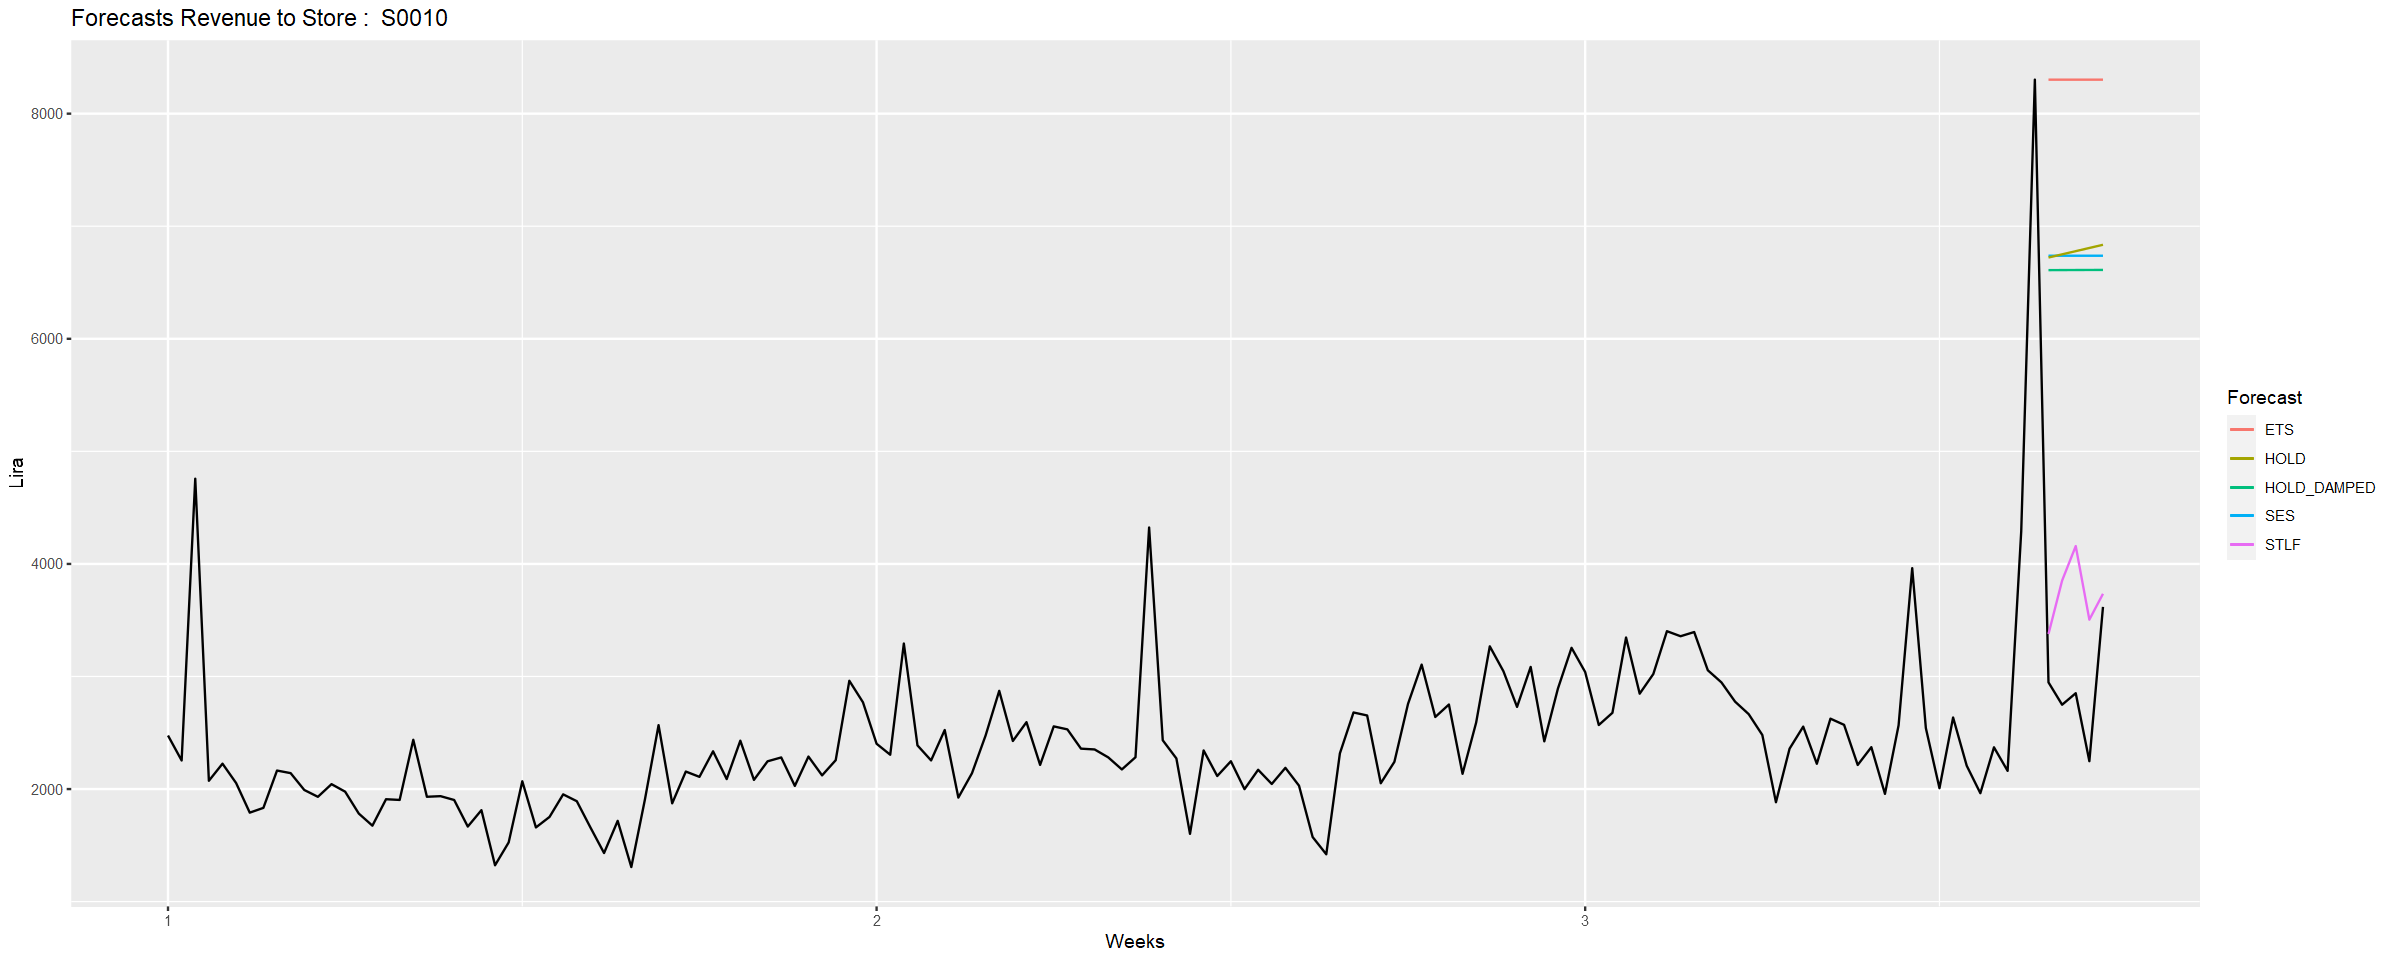

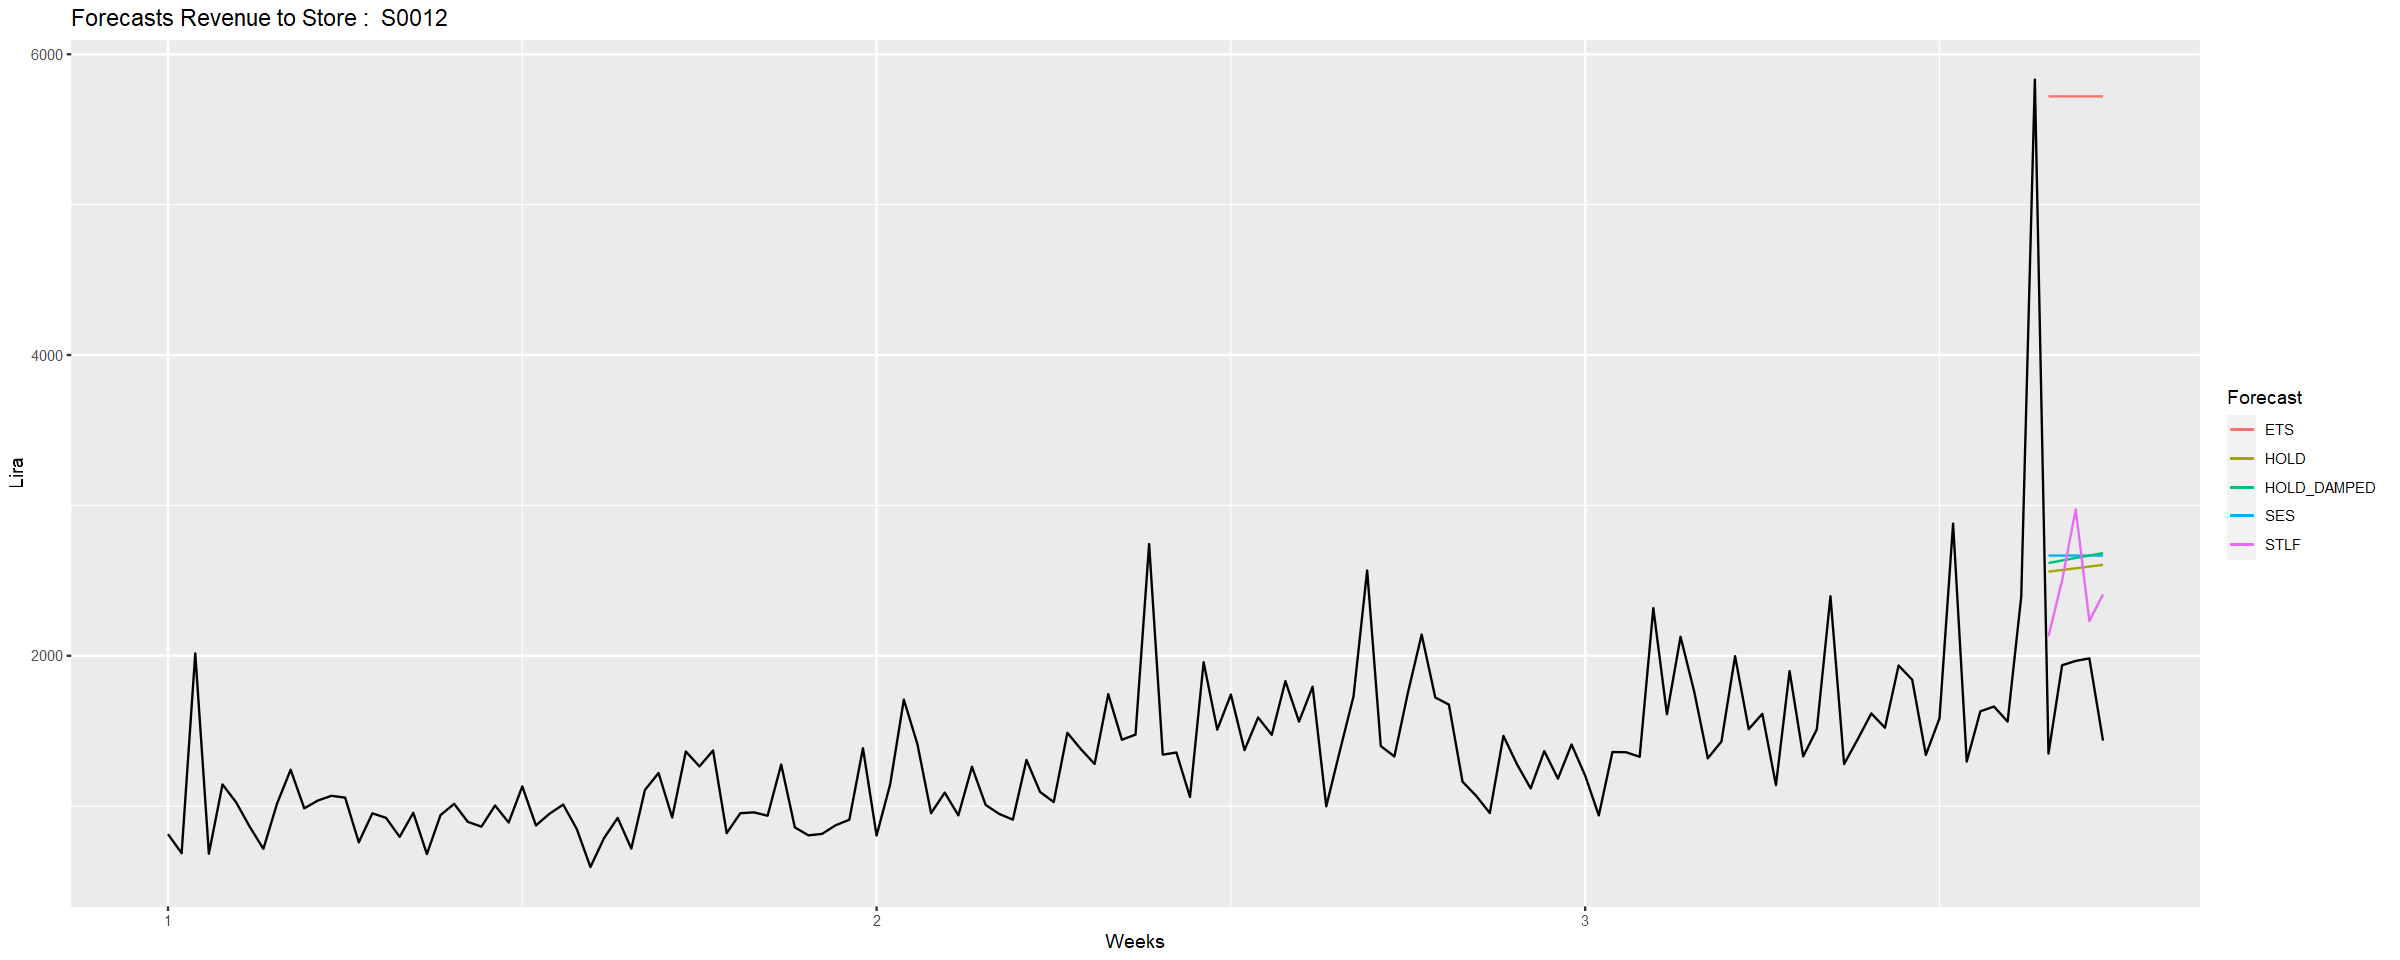

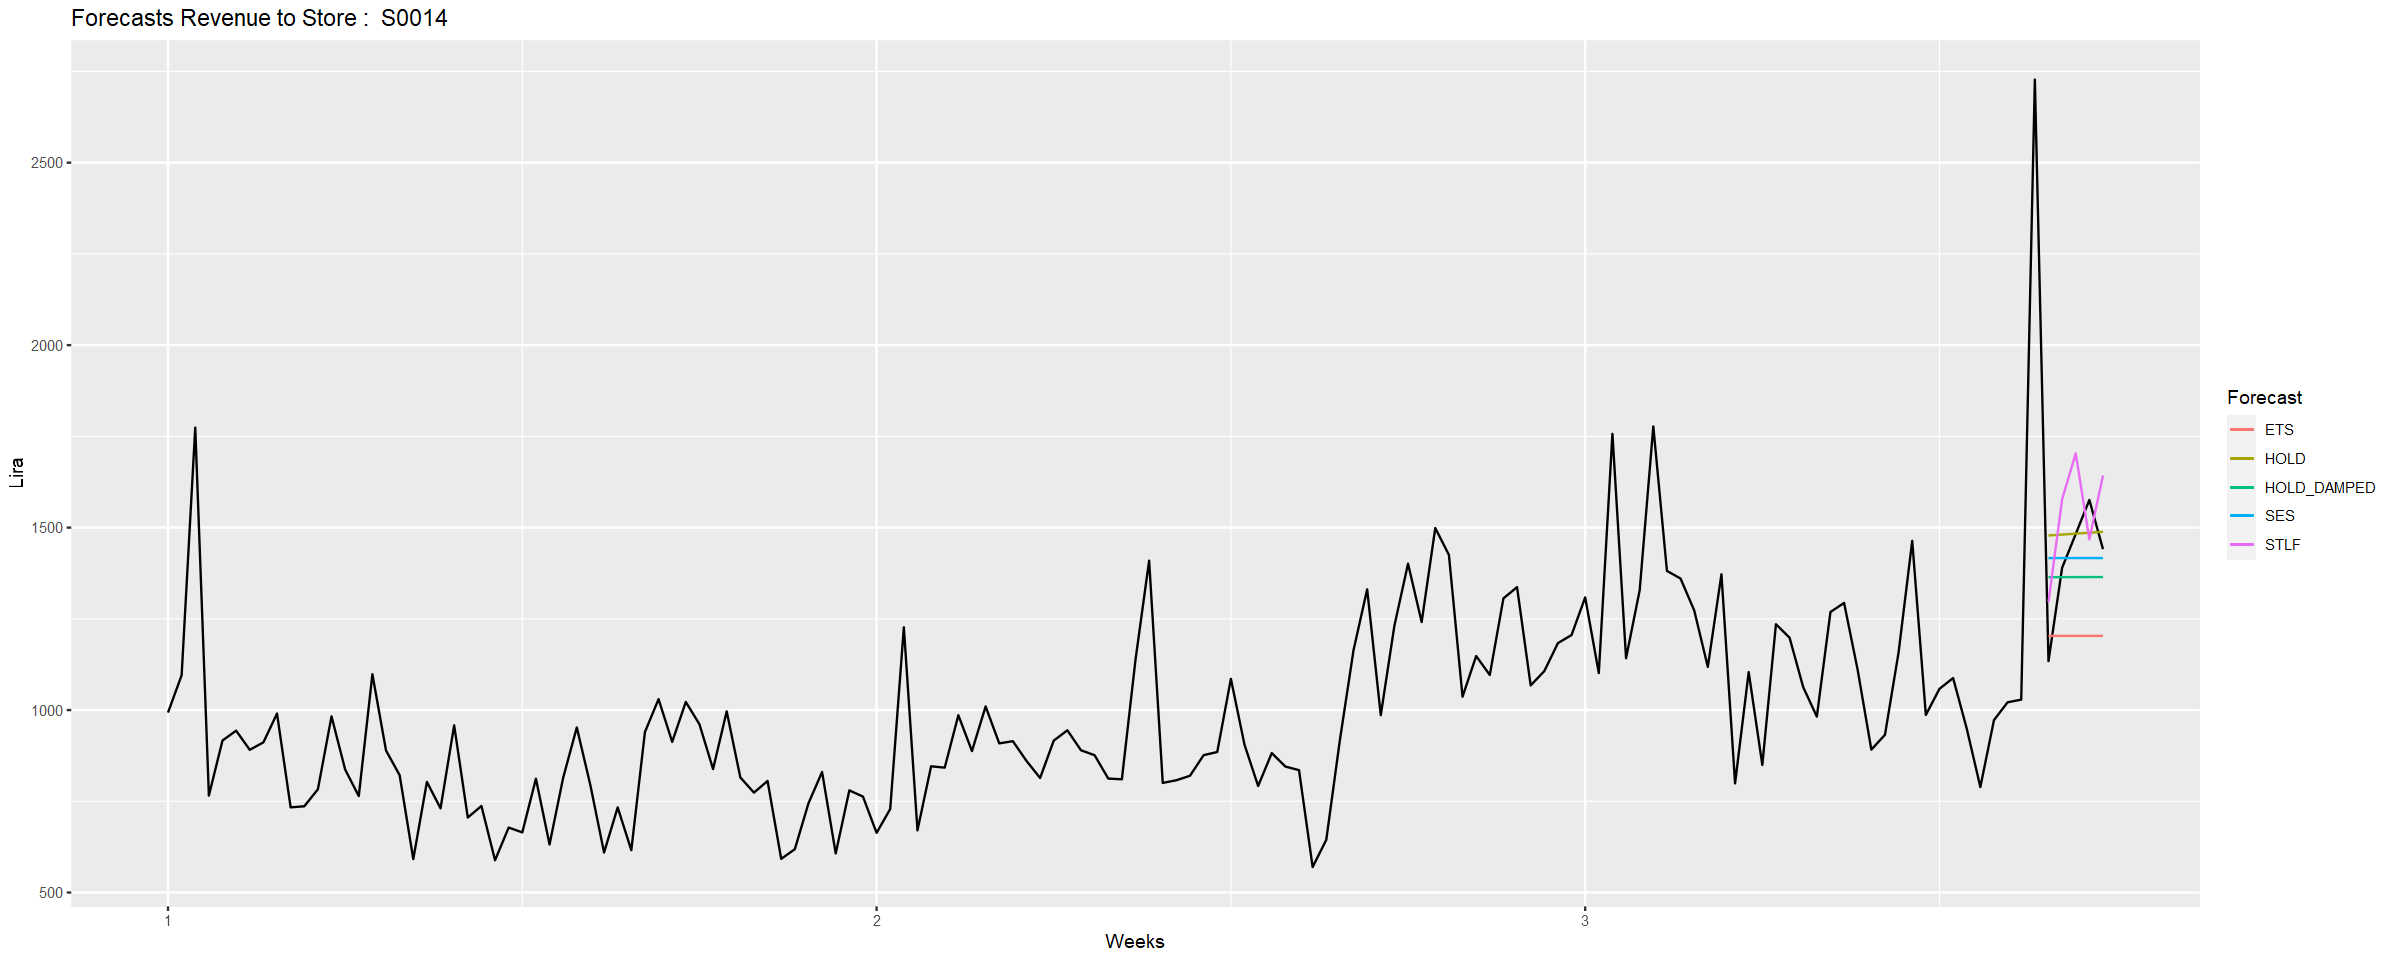

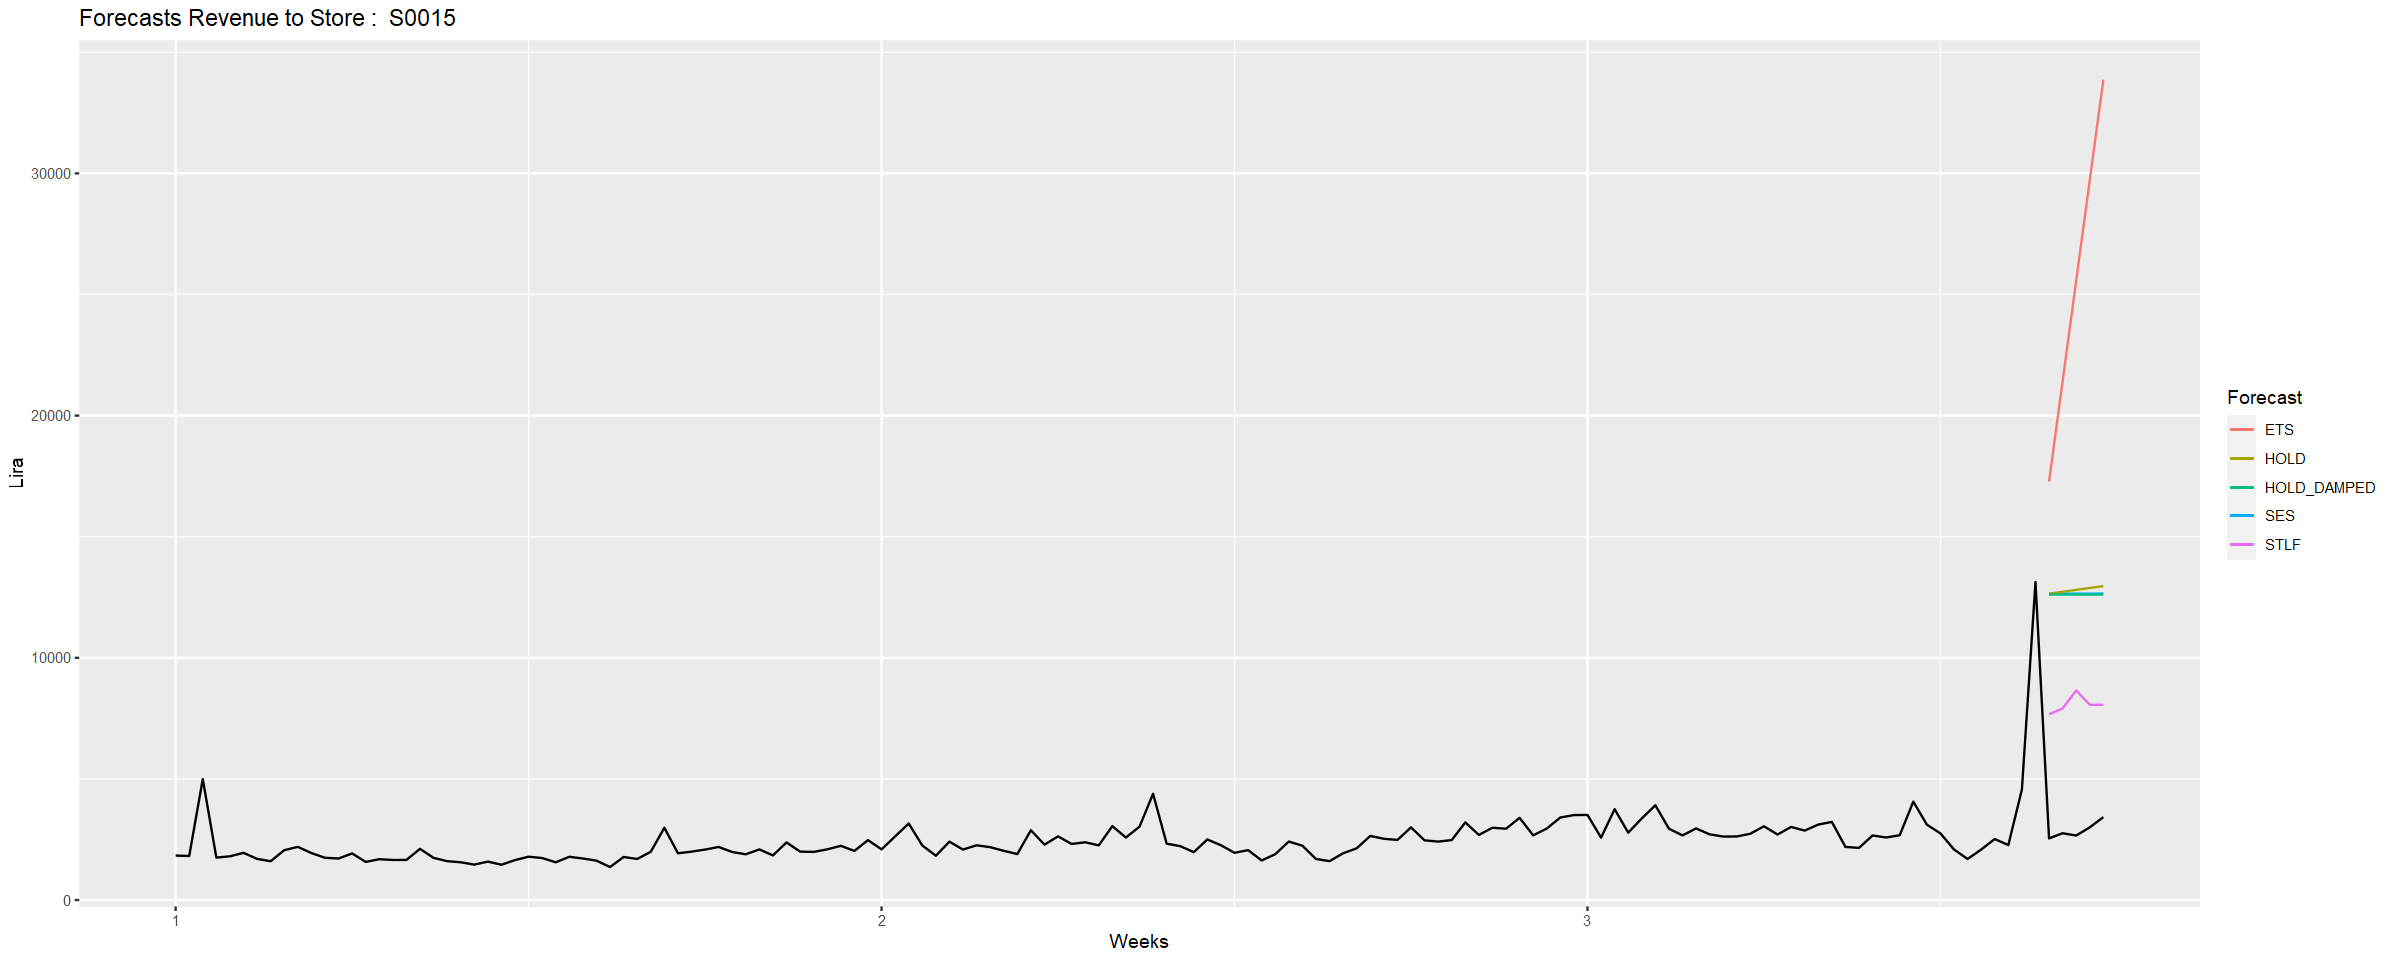

In [16]:
# Ver graficamente as previsões para 3 lojas
options(repr.plot.width = 20, repr.plot.height = 8)

for (i in 5:length(ts_train)) {
  ts_name <- names(ts_train)[i]
  ts <- ts_train[[ts_name]]
  if (i <= 8) {
    plot <- autoplot(ts_real[[i]]) +
    autolayer(ses_prev[[i]], series = "SES")+
    autolayer(holt_prev[[i]], series = "HOLD")+
    autolayer(holt_damped_prev[[i]], series = "HOLD_DAMPED")+
    autolayer(ets_prev[[i]], series = "ETS")+
    autolayer(stlf_prev[[i]], series = "STLF")+
    ggtitle(paste("Forecasts Revenue to Store : ",ts_name))+
    xlab("Weeks") + ylab("Lira") +
    guides(colour=guide_legend(title="Forecast"))
      
    print(plot)
  }
}

## Evaluation


In [17]:
# Criar uma lista para armazenar as métricas de accuracy
accuracy_list_ses <- list()
accuracy_list_holt <- list()
accuracy_list_holt_damped <- list()
accuracy_list_ets <- list()
accuracy_list_stlf <- list()
# Calcular a accuracy para modelos hold
for (ts in names(ses_prev)) {
      # Obter os valores reais
      real_values <- as.vector(coredata(ts_test[[ts]]))
      # Obter as previsões
      predicts <- as.vector(coredata(ses_prev[[ts]]))
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_ses[[ts]] <- accuracy
}
# Calcular a accuracy para modelos hold
for (ts in names(holt_prev)) {
      # Obter os valores reais
      real_values <- as.vector(coredata(ts_test[[ts]]))
      # Obter as previsões
      predicts <- as.vector(coredata(holt_prev[[ts]]))
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_holt[[ts]] <- accuracy
}
# Calcular a accuracy para modelos hold_damped
for (ts in names(holt_damped_prev)) {
      # Obter os valores reais
      real_values <- as.vector(coredata(ts_test[[ts]]))
      # Obter as previsões
      predicts <- as.vector(coredata(holt_damped_prev[[ts]]))
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_holt_damped[[ts]] <- accuracy
}
# Calcular a accuracy para modelos ets
for (ts in names(ets_prev)) {
      # Obter os valores reais
      real_values <- as.vector(coredata(ts_test[[ts]]))
      # Obter as previsões
      predicts <- as.vector(coredata(ets_prev[[ts]]))
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_ets[[ts]] <- accuracy
}
# Calcular a accuracy para modelos stlf
for (ts in names(stlf_prev)) {
      # Obter os valores reais
      real_values <- as.vector(coredata(ts_test[[ts]]))
      # Obter as previsões
      predicts <- as.vector(coredata(stlf_prev[[ts]]))
      # Calcular a accuracy
      accuracy <- accuracy(real_values, predicts)
      # Armazenar as métricas de accuracy na lista
      accuracy_list_stlf[[ts]] <- accuracy
}
# Converter a lista de accuracy em um DataFrame
df_accuracy_ses <- do.call(rbind, accuracy_list_ses)
df_accuracy_holt <- do.call(rbind, accuracy_list_holt)
df_accuracy_holt_damped <- do.call(rbind, accuracy_list_holt_damped)
df_accuracy_ets <- do.call(rbind, accuracy_list_ets)
df_accuracy_stlf <- do.call(rbind, accuracy_list_stlf)
# Adicionar coluna "store_id" com os valores de ts
df_accuracy_ses <- cbind(store_id = names(ses_prev), df_accuracy_ses)
df_accuracy_ses <- as.data.frame(df_accuracy_ses, row.names = NULL)
df_accuracy_holt <- cbind(store_id = names(holt_prev), df_accuracy_holt)
df_accuracy_holt <- as.data.frame(df_accuracy_holt, row.names = NULL)
df_accuracy_holt_damped <- cbind(store_id = names(holt_damped_prev), df_accuracy_holt_damped)
df_accuracy_holt_damped <- as.data.frame(df_accuracy_holt_damped, row.names = NULL)
df_accuracy_ets <- cbind(store_id = names(ets_prev), df_accuracy_ets)
df_accuracy_ets <- as.data.frame(df_accuracy_ets, row.names = NULL)
df_accuracy_stlf <- cbind(store_id = names(stlf_prev), df_accuracy_stlf)
df_accuracy_stlf <- as.data.frame(df_accuracy_stlf, row.names = NULL)
# Adicionar sufixo  colunas
colnames(df_accuracy_ses)[-1] <- paste(colnames(df_accuracy_ses)[-1], "_ses", sep = "")
colnames(df_accuracy_holt)[-1] <- paste(colnames(df_accuracy_holt)[-1], "_holt", sep = "")
colnames(df_accuracy_holt_damped)[-1] <- paste(colnames(df_accuracy_holt_damped)[-1], "_holt_dumped", sep = "")
colnames(df_accuracy_ets)[-1] <- paste(colnames(df_accuracy_ets)[-1], "_ets", sep = "")
colnames(df_accuracy_stlf)[-1] <- paste(colnames(df_accuracy_stlf)[-1], "_stlf", sep = "")

In [18]:
# Merge dataframes
df_combined <- Reduce(function(x, y) merge(x, y, by = "store_id"), 
                      list(df_accuracy_ses, df_accuracy_holt, df_accuracy_holt_damped, 
                           df_accuracy_ets, df_accuracy_stlf))
head(df_combined)

,store_id,ME_ses,RMSE_ses,MAE_ses,MPE_ses,MAPE_ses,ME_holt,RMSE_holt,MAE_holt,MPE_holt,⋯,ME_ets,RMSE_ets,MAE_ets,MPE_ets,MAPE_ets,ME_stlf,RMSE_stlf,MAE_stlf,MPE_stlf,MAPE_stlf
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,S0002,4881.26017223581,5011.2299776298,4881.26017223581,50.1679894286803,50.1679894286803,4962.47879368508,5091.00914015986,4962.47879368508,50.5771707471595,⋯,11434.0405008916,11490.1265091238,11434.0405008916,70.222403835463,70.222403835463,2666.40872542997,3004.47690959476,2666.40872542997,34.8394574064348,34.8394574064348
2,S0003,718.153146020632,726.31032637801,718.153146020632,36.8749395865451,36.8749395865451,161.71582160291,190.253707303001,161.71582160291,11.6646025162203,⋯,4572.22377763714,4573.51211016812,4572.22377763714,78.8095981817527,78.8095981817527,870.907370571902,955.095876402425,870.907370571902,39.9358833557383,39.9358833557383
3,S0005,-9.95199022317925,66.6754272982352,58.4567980446358,-0.849692561605873,4.99099228997798,655.602366108695,658.163285407222,655.602366108695,35.7030434285211,⋯,2096.78519115756,2097.82141955736,2096.78519115756,63.9657090620138,63.9657090620138,NaN,NaN,NaN,NaN,NaN
4,S0007,-107.172956771604,164.795333256643,147.075774062962,-13.6422301605386,18.721528464333,57.5839604686632,127.25255650187,96.9423690907785,6.19990029000218,⋯,87.9823437082237,142.616223684819,114.165921011942,9.11543408278359,11.717913935905,NaN,NaN,NaN,NaN,NaN
5,S0010,3855.01338366179,3880.03072385613,3855.01338366179,57.2135700946237,57.2135700946237,3895.59965104598,3919.34908828096,3895.59965104598,57.4784967037658,⋯,5418.87527736494,5436.70115984804,5418.87527736494,65.2735196526617,65.2735196526617,842.55238731134,969.844599171993,842.55238731134,22.3518650126749,22.3518650126749
6,S0012,932.050190327832,973.321790543162,932.050190327832,34.9557946914014,34.9557946914014,847.658844583335,892.430054785939,847.658844583335,32.8350085227275,⋯,3985.21523349387,3995.06923693791,3985.21523349387,69.6772808339718,69.6772808339718,714.394347105354,767.888159731538,714.394347105354,28.9111973250034,28.9111973250034


In [19]:
# Exportar resultados
# Accuracy dataframe
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "accuracyEtsModels.csv")
write.csv(df_combined, file = path, row.names = FALSE)
# Resultado previsões em dados teste
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "resultEtsModels.csv")
write.csv(prev, file = path, row.names = FALSE)
print('Exportação concluida!')

[1] "Exportação concluida!"
